##  GR DUSP1 Gating Notebook

The Purpose of this notebook is:
1) Load in all analyisis for final dataframe preparation (GR_Confirmation)
3) Filter GR data to remove partial cells
4) Estimate GR cytoplasmic area from DUPS1 data
5) GR intensity to molecular counts 
6) Concatonate final GR and DUSP1 dataframes

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns
import datetime
import glob

# Today's date
today = datetime.date.today()
# Format date as 'Jun03' (for example)
date_str = today.strftime("%b%d")

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1 import DUSP1DisplayManager, PostProcessingPlotter, ExperimentPlotter

/Users/ericron/Desktop/AngelFISH


In [2]:
# Base directory containing your CSV files
base_dir = "/Volumes/share/Users/Eric/GR_DUSP1_AllData/DUSP1_AllAnalysis_061725"
save_dir = "/Volumes/share/Users/Eric/GR_DUSP1_AllData/DUSP1_AllAnalysis_061725/ConcatPlots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
# Helper to load and concat by pattern
def load_and_concat(pattern):
    paths = glob.glob(os.path.join(base_dir, pattern))
    dfs = []
    for path in paths:
        df = pd.read_csv(path)
        # normalize columns to lowercase
        df.columns = [c.lower() for c in df.columns]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [ ]:
# Load each dataset
ssit_all      = load_and_concat("*_SSITcellresults.csv")
# collapse “G_day1_mean” → “G”, etc.
ssit_all['replica'] = ssit_all['replica'].str.replace(r'_day.*', '', regex=True)

spots_all     = load_and_concat("*_FinalSpots.csv")
clusters_all  = load_and_concat("*_FinalClusters.csv")
cellprops_all = load_and_concat("*_FinalCellProps.csv")

# Quick check on length of each dataset
print(f"SSIT cells: {len(ssit_all)}")
print(f"Spots:      {len(spots_all)}")
print(f"Clusters:   {len(clusters_all)}")
print(f"Cell props: {len(cellprops_all)}")

In [ ]:
# Compute quartiles on 'nuc_area'
q_low  = cellprops_all['nuc_area'].quantile(0.25)
q_high = cellprops_all['nuc_area'].quantile(0.75)

# Filter cellprops by nuclear area range
gated_cells = cellprops_all[(cellprops_all['nuc_area'] >= q_low) &
                             (cellprops_all['nuc_area'] <= q_high)].copy()

# Extract unique_cell_ids for gating
gated_ids = gated_cells['unique_cell_id'].unique()

# Subset SSIT and clusters by gated unique_cell_id
ssit_gated     = ssit_all[ssit_all['unique_cell_id'].isin(gated_ids)].copy()
clusters_gated = clusters_all[clusters_all['unique_cell_id'].isin(gated_ids)].copy()
spots_gated    = spots_all[spots_all['unique_cell_id'].isin(gated_ids)].copy()

display(gated_cells.shape, ssit_gated.shape, clusters_gated.shape, spots_gated.shape)

# Print cells before and after gating
print(f"Cells before gating: {cellprops_all['unique_cell_id'].nunique()}")
print(f"Cells after gating: {gated_cells['unique_cell_id'].nunique()}")
# Print spots before and after gating
print(f"Spots before gating: {spots_all['unique_cell_id'].nunique()}")
print(f"Spots after gating: {spots_gated['unique_cell_id'].nunique()}")
# Print clusters before and after gating
print(f"Clusters before gating: {clusters_all['unique_cell_id'].nunique()}")
print(f"Clusters after gating: {clusters_gated['unique_cell_id'].nunique()}")

# Save the gated data
gated_cells.to_csv(os.path.join(save_dir, f'gated_cells_{date_str}.csv'), index=False)
ssit_gated.to_csv(os.path.join(save_dir, f'ssit_gated_{date_str}.csv'), index=False)
clusters_gated.to_csv(os.path.join(save_dir, f'clusters_gated_{date_str}.csv'), index=False)
spots_gated.to_csv(os.path.join(save_dir, f'spots_gated_{date_str}.csv'), index=False)

In [3]:
# Load the gated data (if already saved)
# gated_cells = pd.read_csv(os.path.join(save_dir, f'gated_cells_{date_str}.csv'))
ssit_gated = pd.read_csv(os.path.join(save_dir, f'ssit_gated_Jun17.csv'))
# clusters_gated = pd.read_csv(os.path.join(save_dir, f'clusters_gated_{date_str}.csv'))
# spots_gated = pd.read_csv(os.path.join(save_dir, f'spots_gated_{date_str}.csv'))

In [ ]:
ssit_gated.keys() # Display keys of the gated SSIT data

In [4]:
# print the number of unique cell IDs in the gated SSIT data
print(f"Unique cell IDs in gated SSIT data: {ssit_gated['unique_cell_id'].nunique()}")

Unique cell IDs in gated SSIT data: 17458


In [5]:
ssit_gated['replica'].unique()  # Display unique replicates in the gated SSIT data

array(['I', 'F', 'N', 'H', 'G', 'D', 'L', 'K', 'M', 'E', 'J'],
      dtype=object)

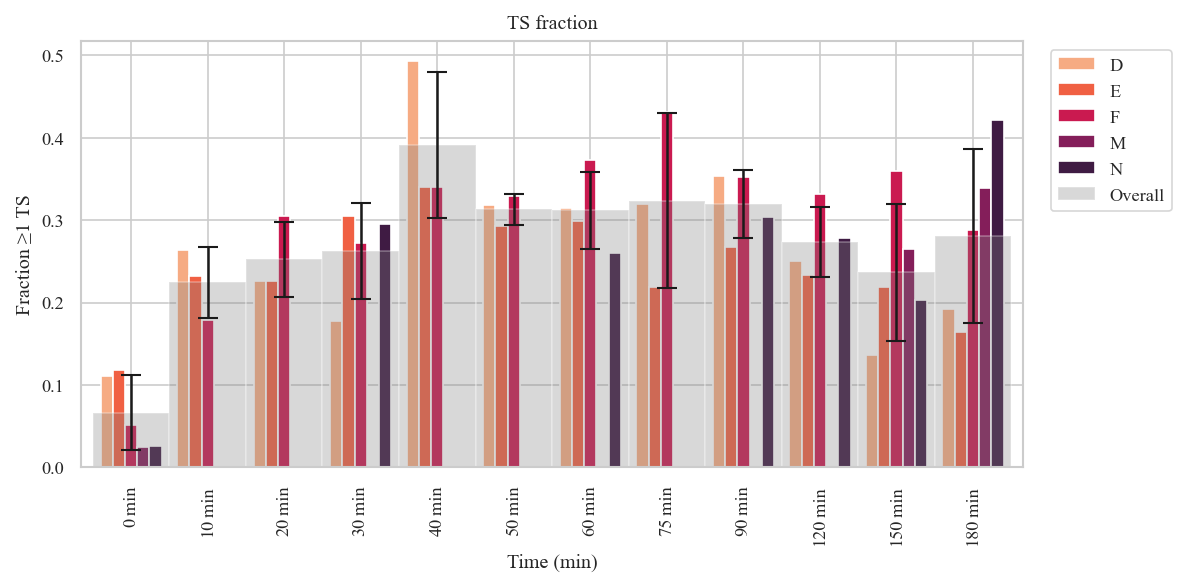

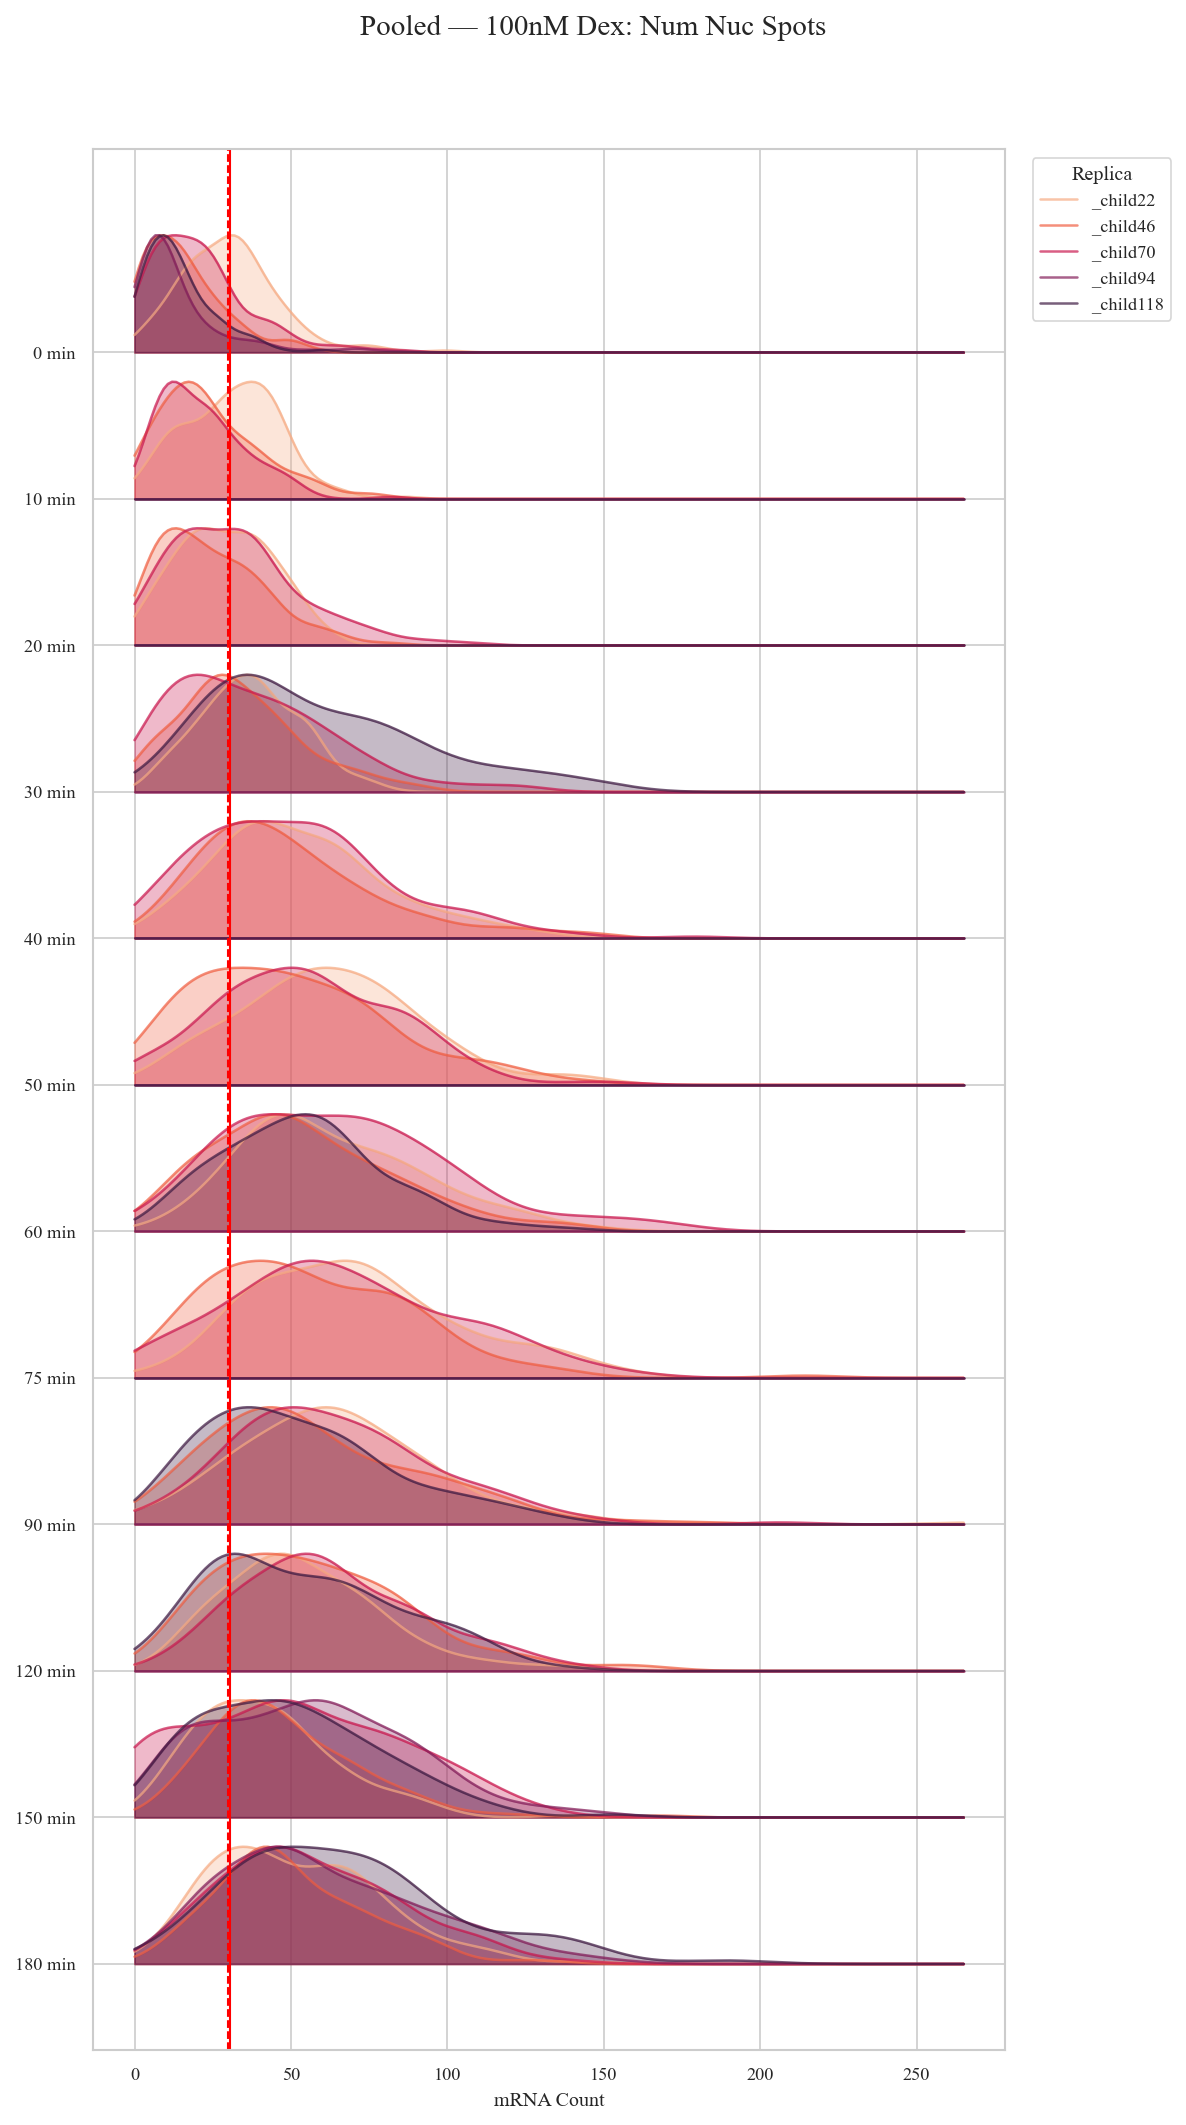

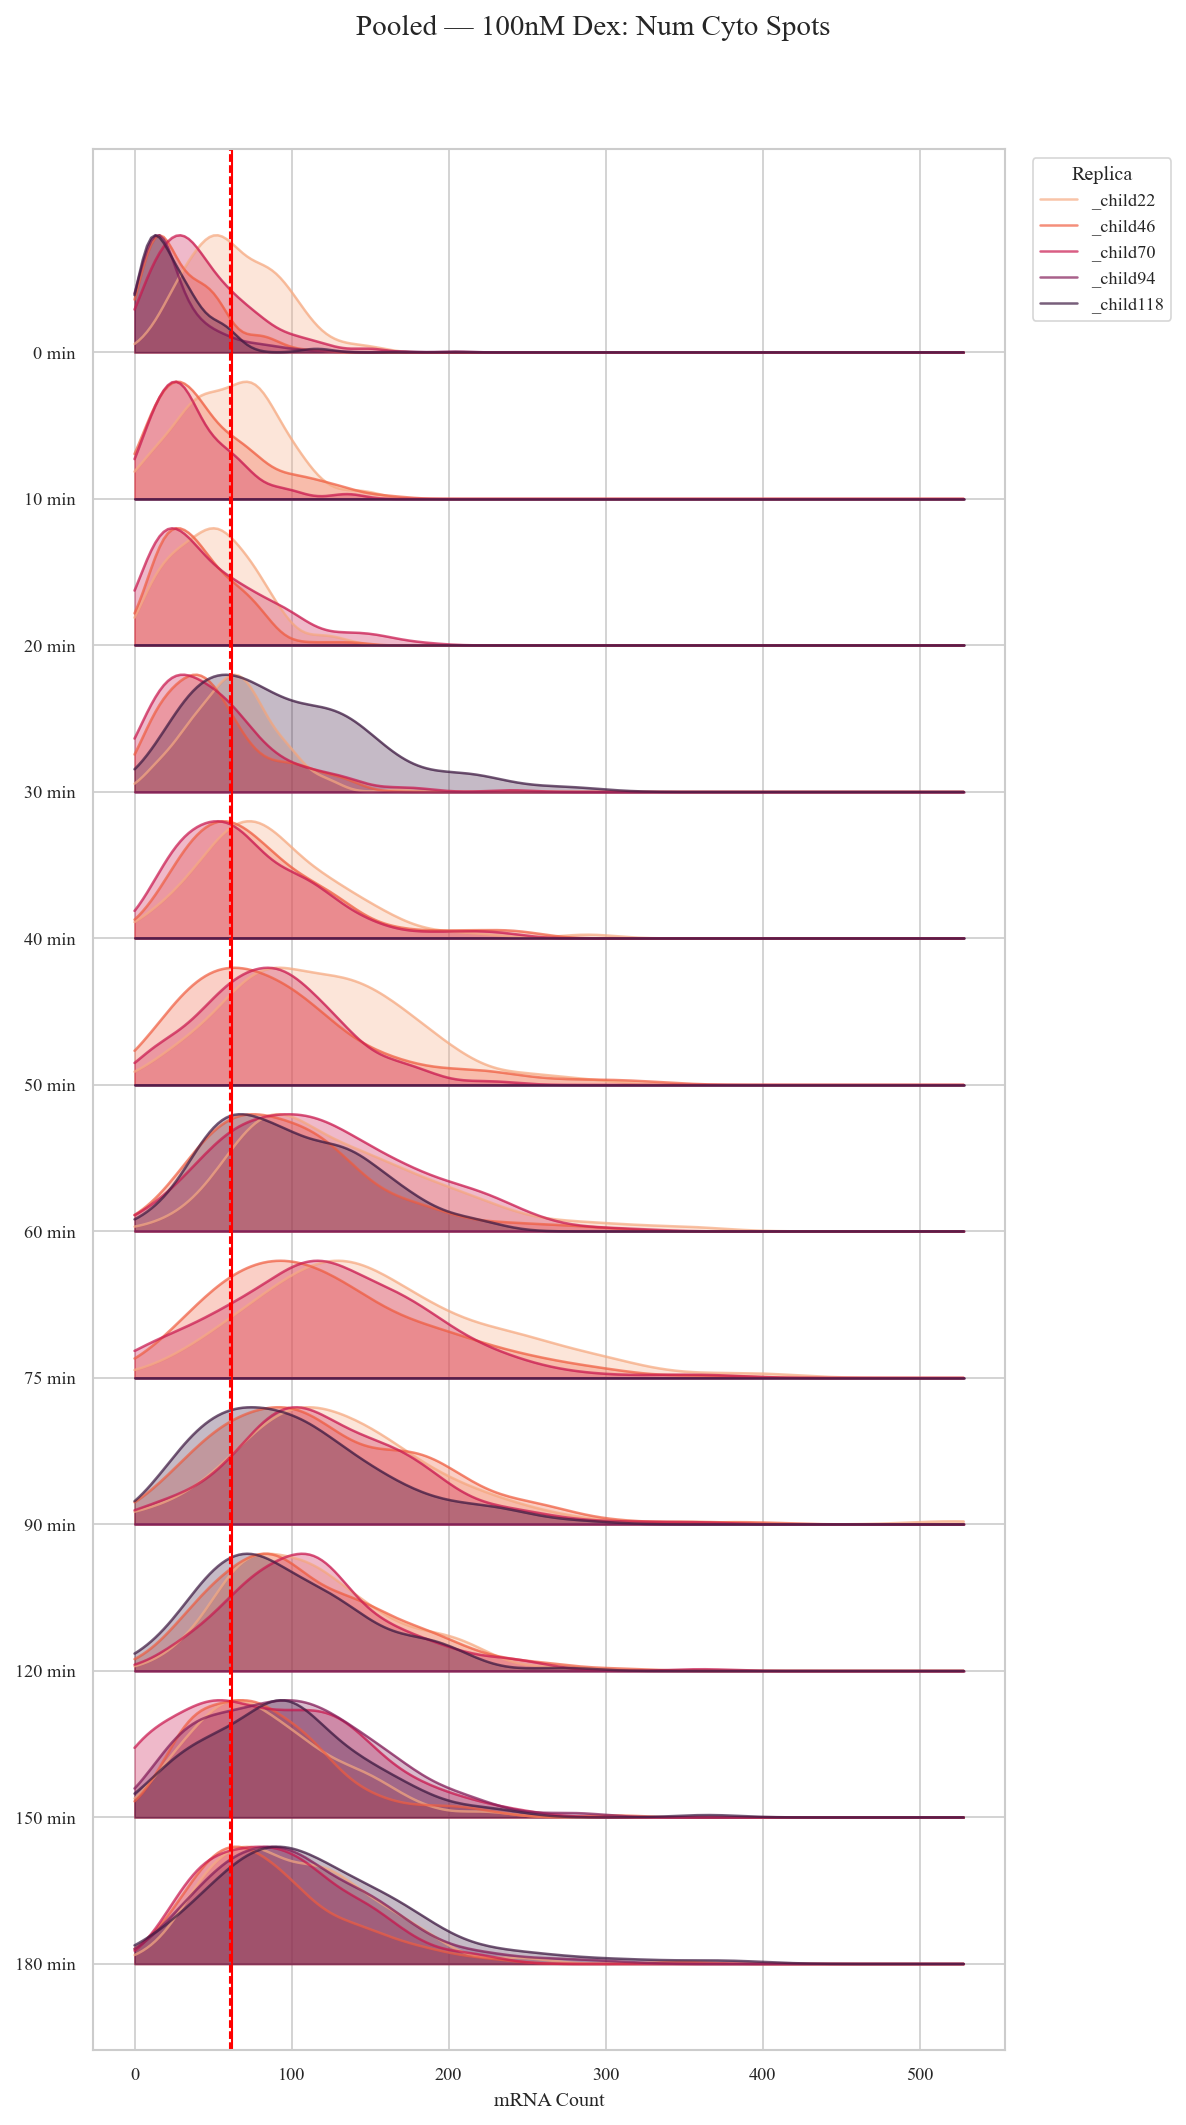

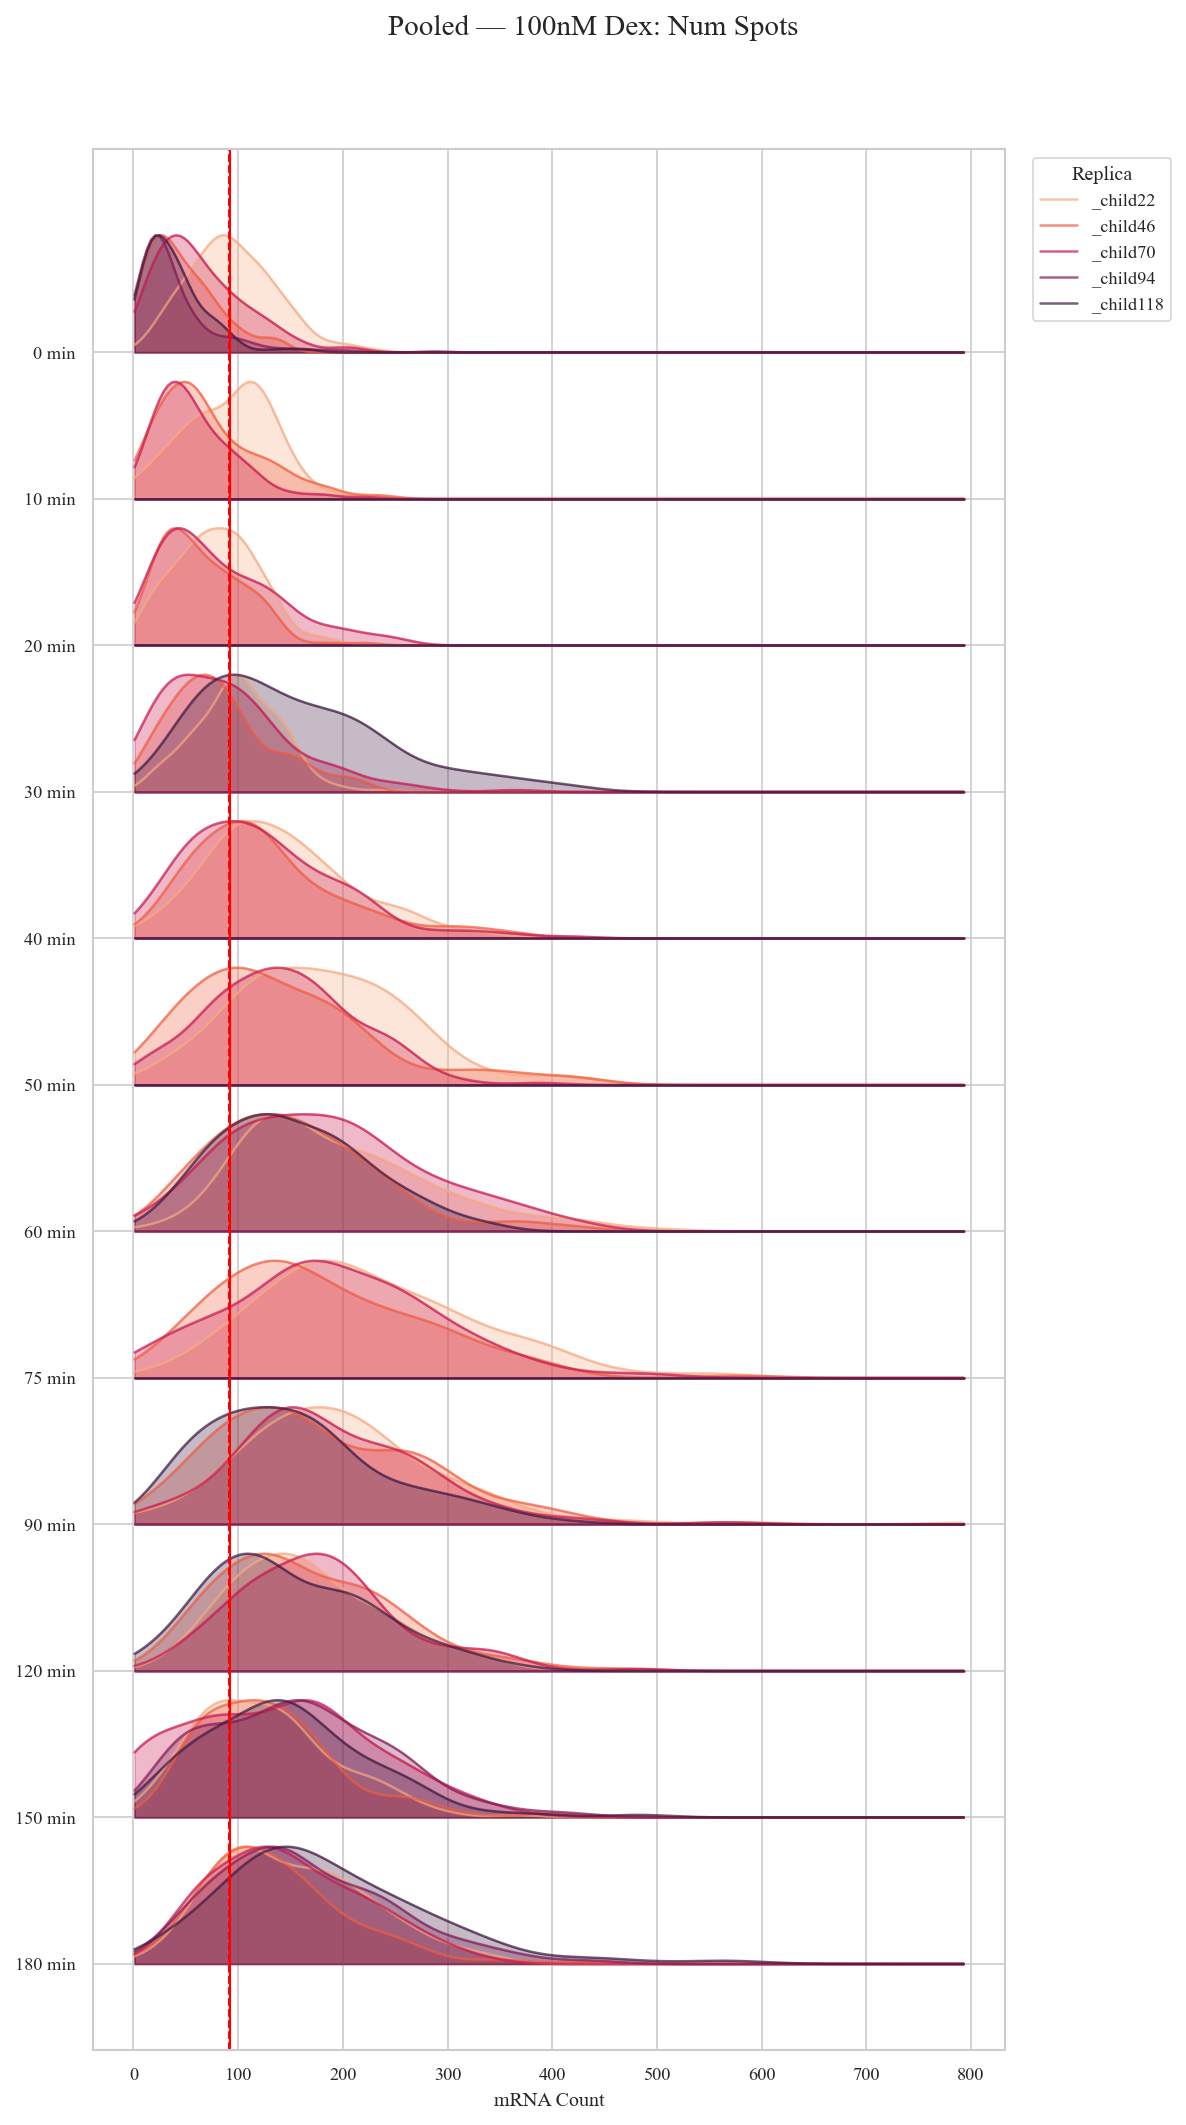

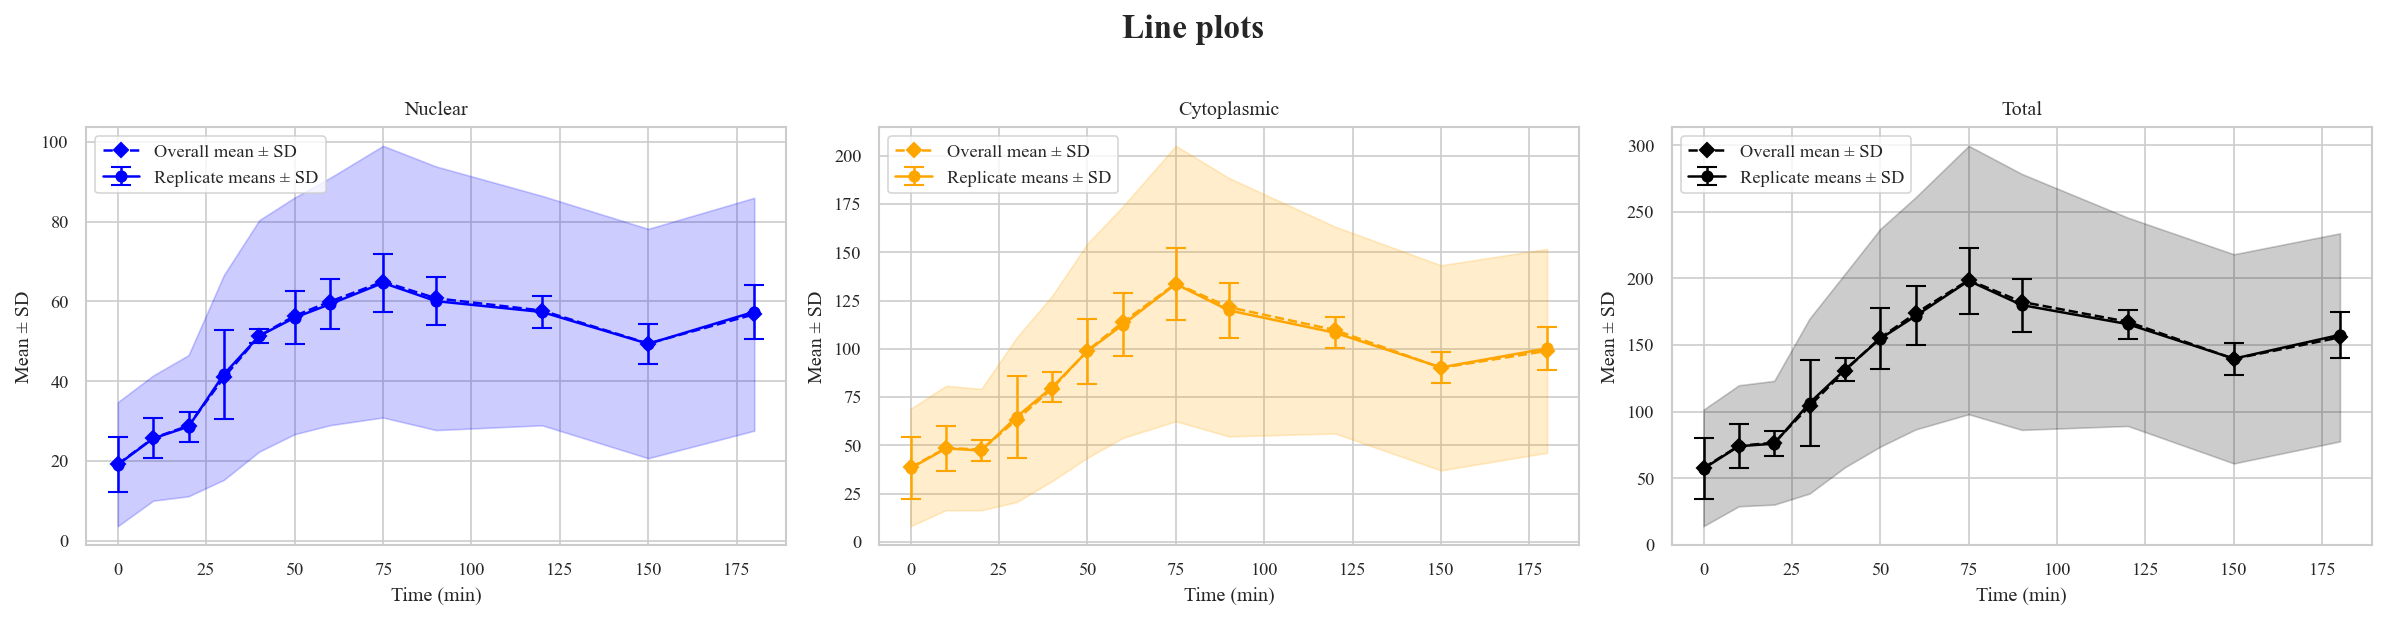

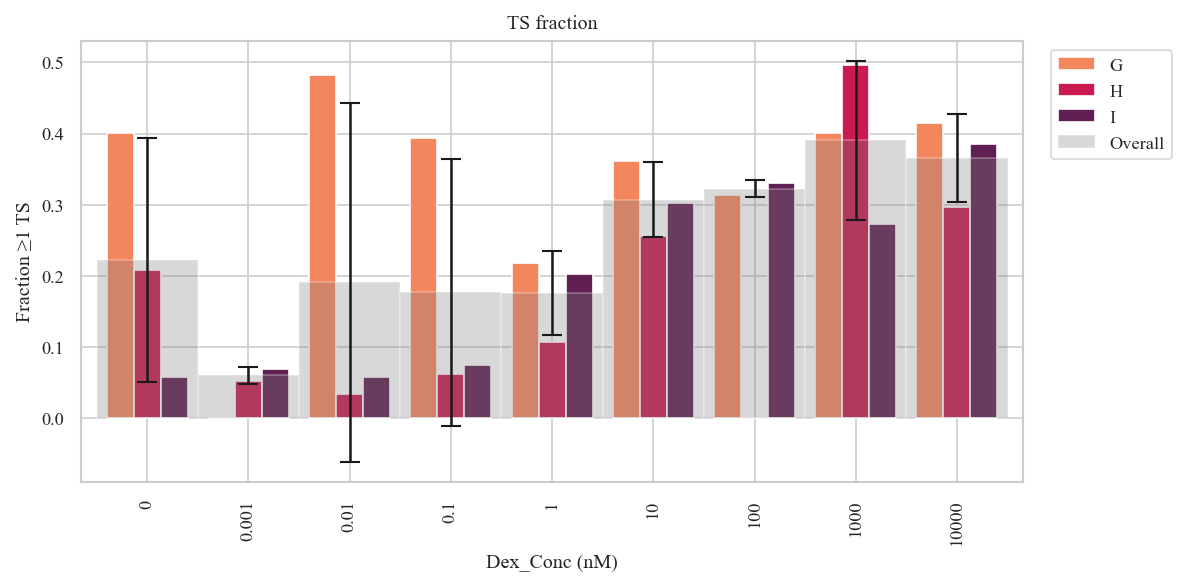

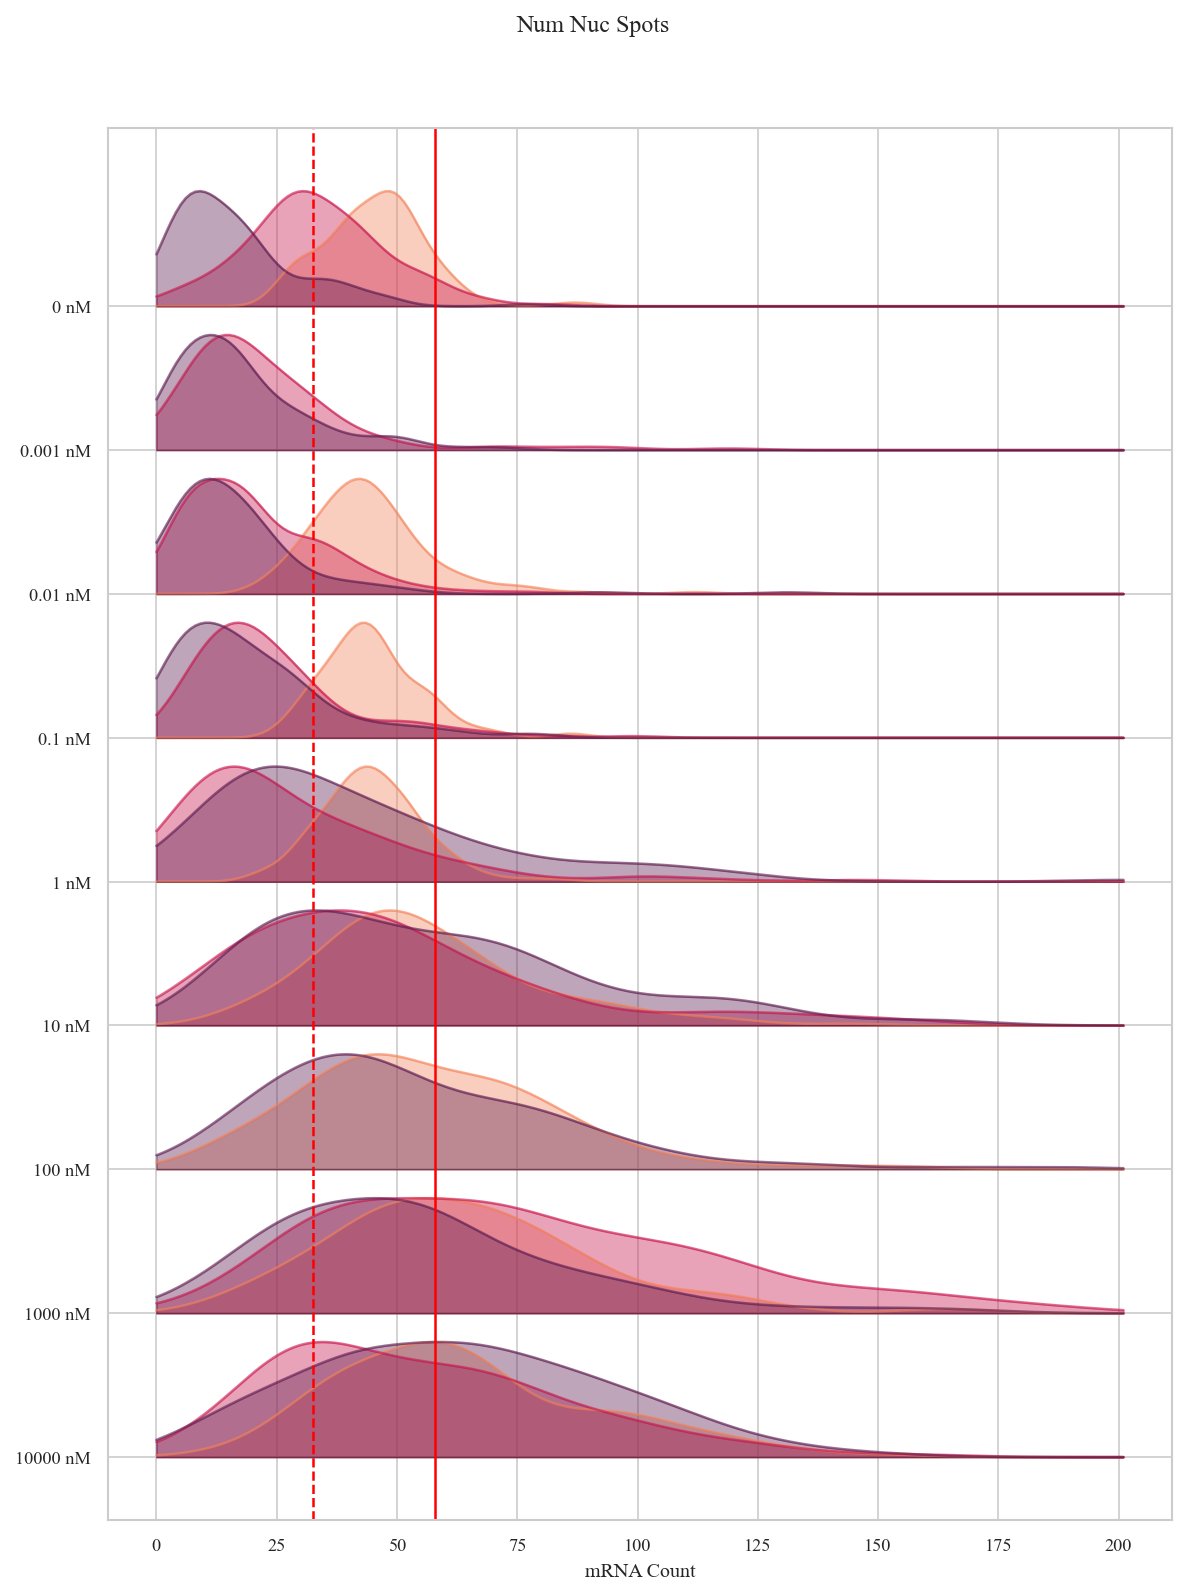

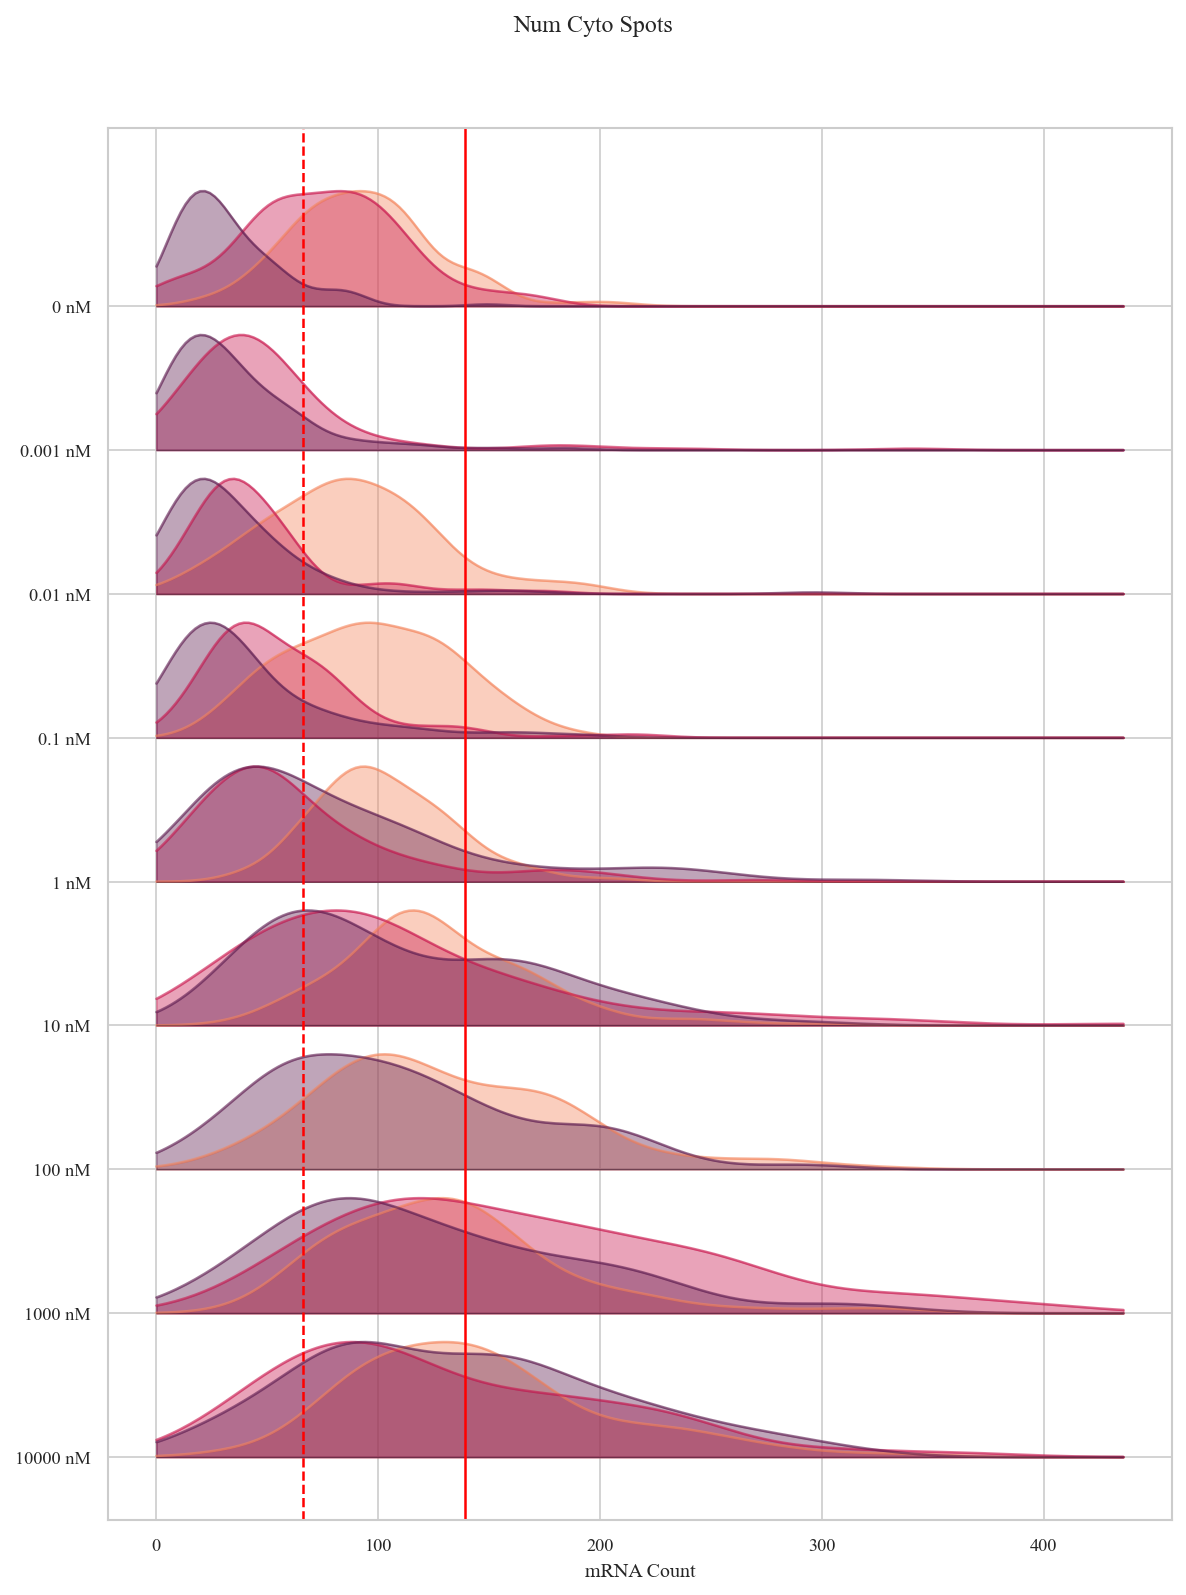

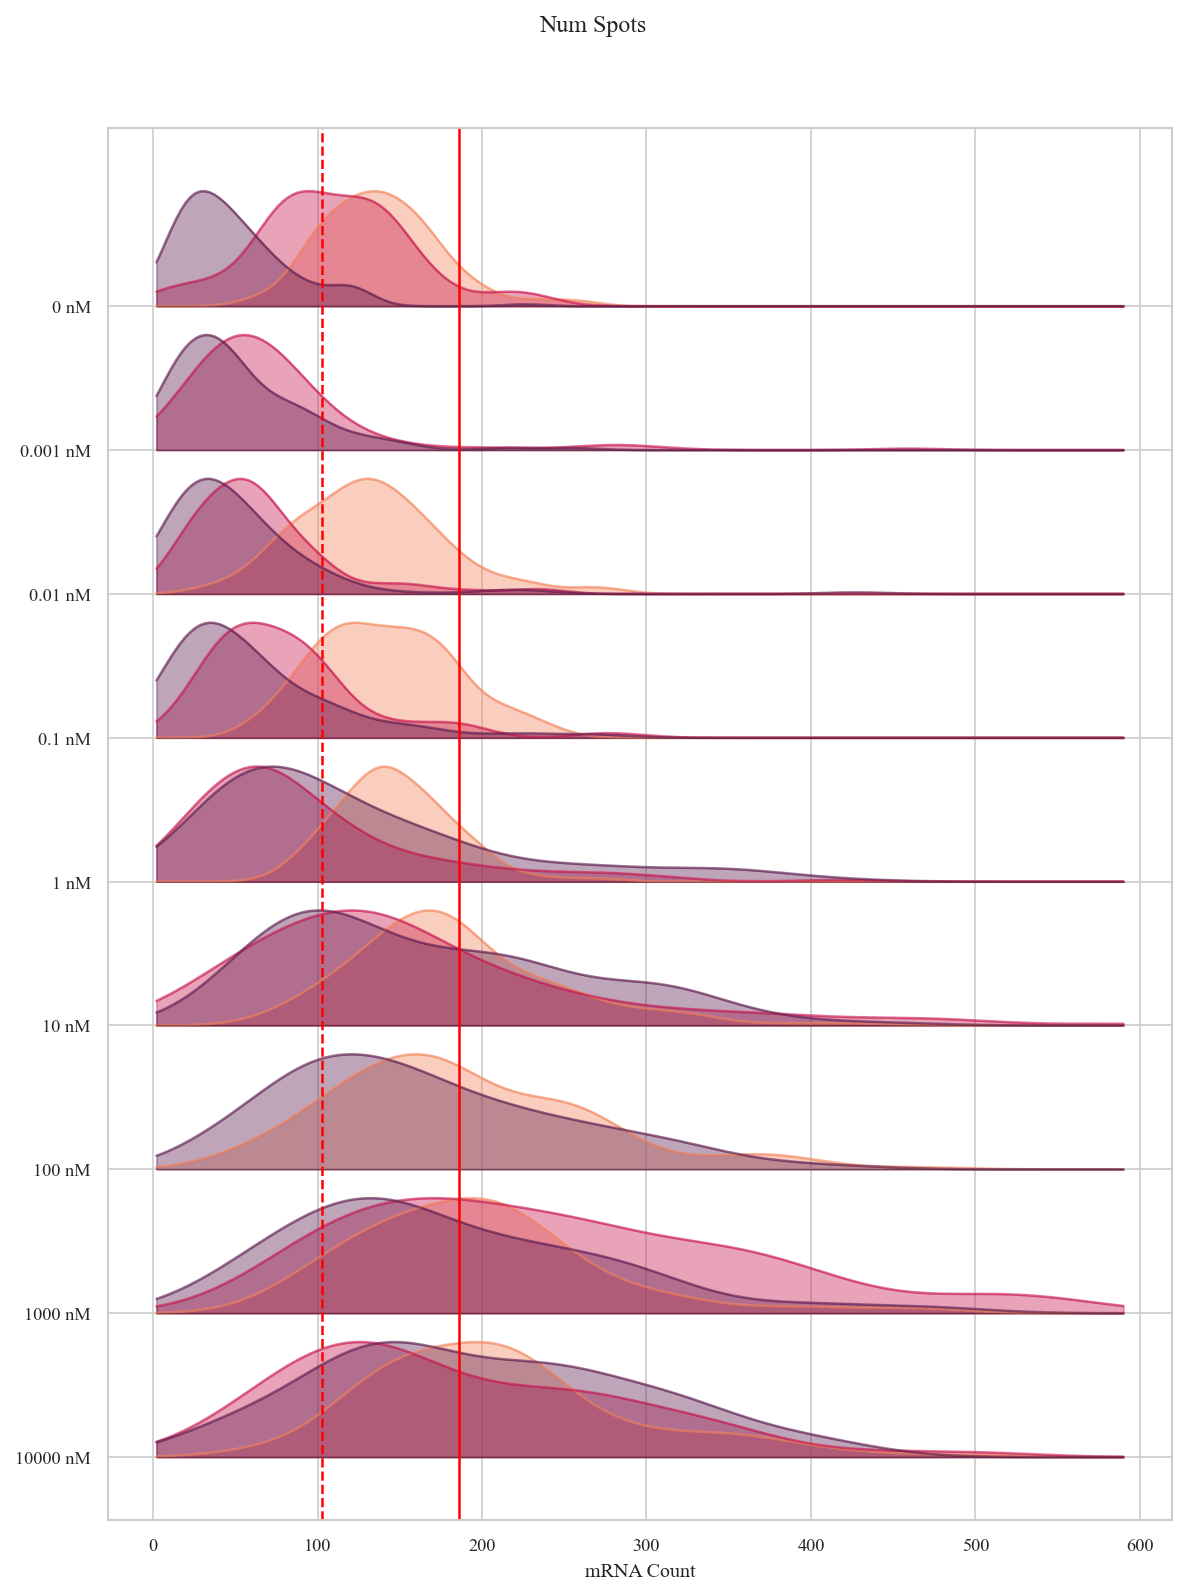

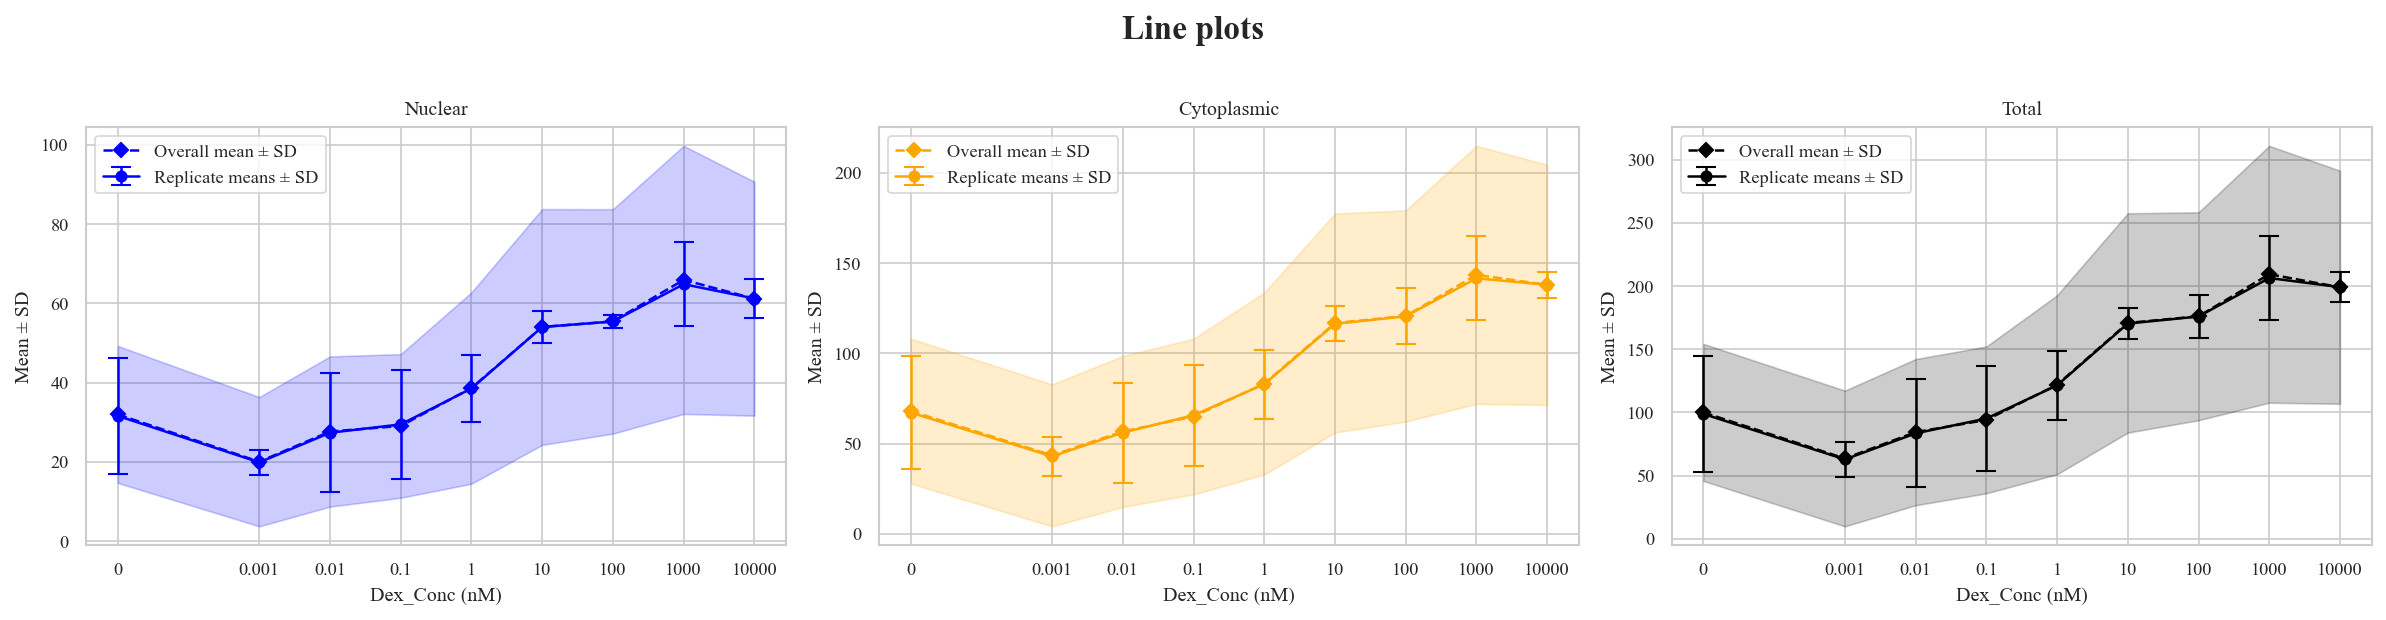

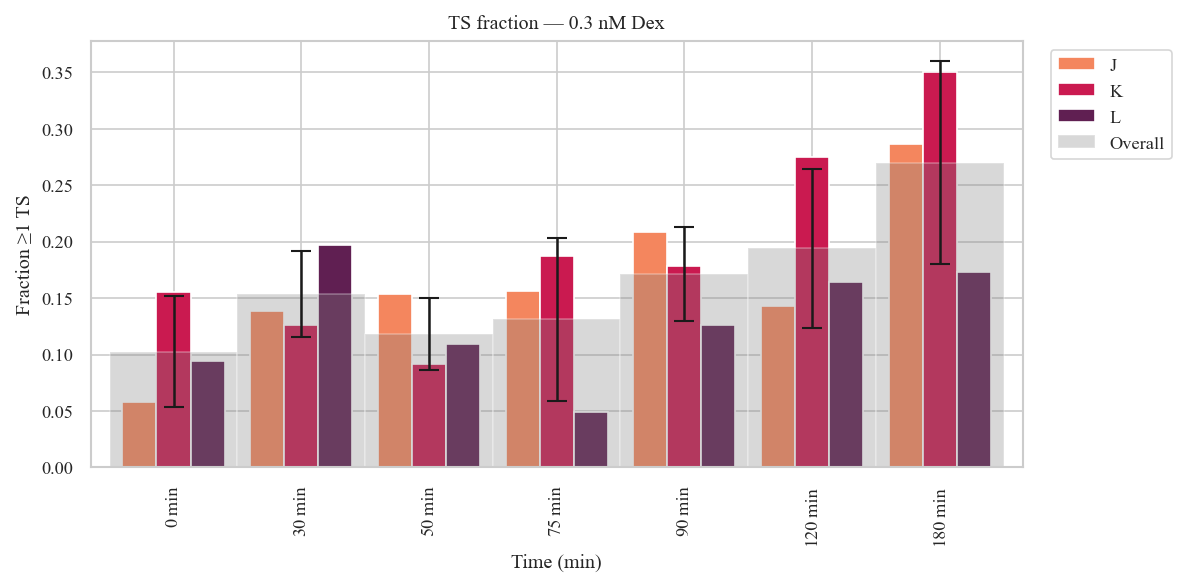

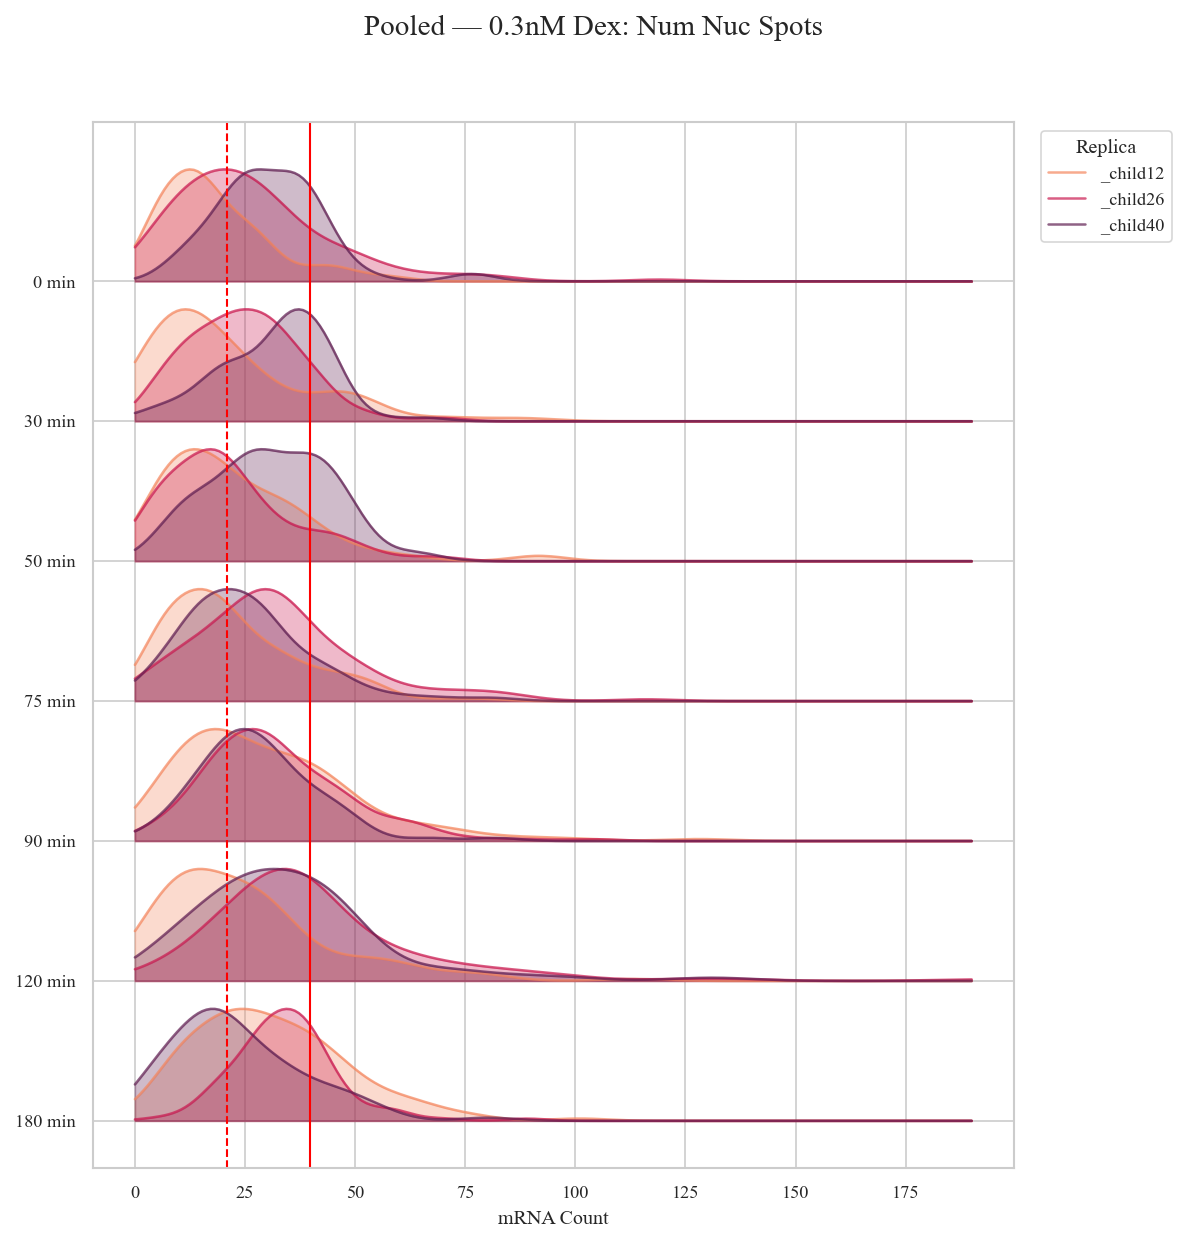

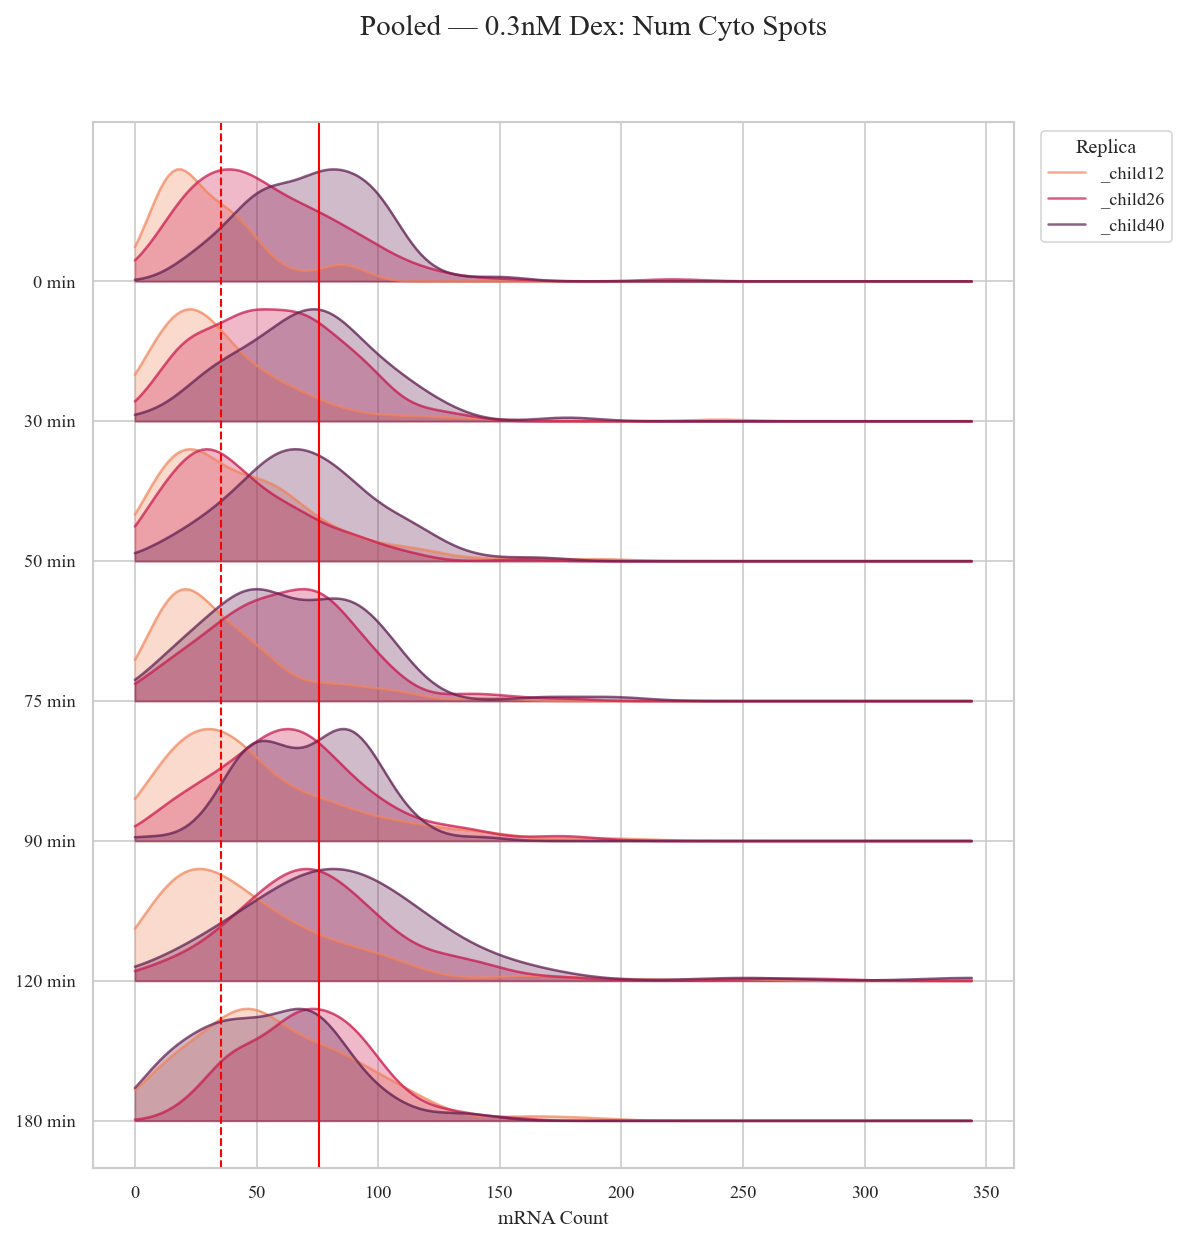

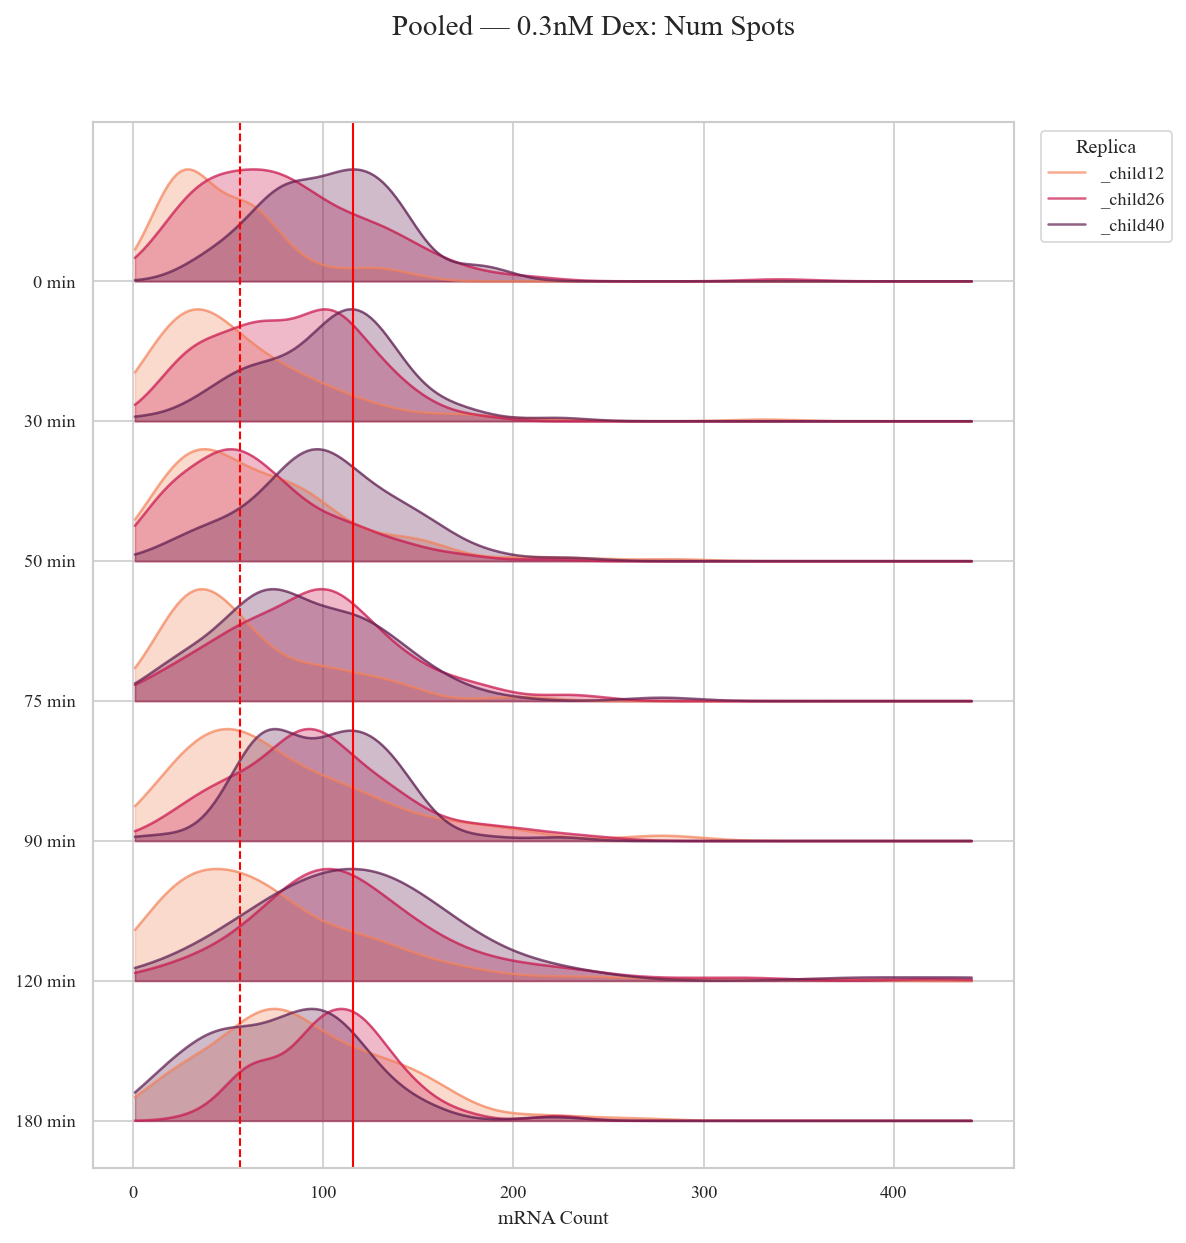

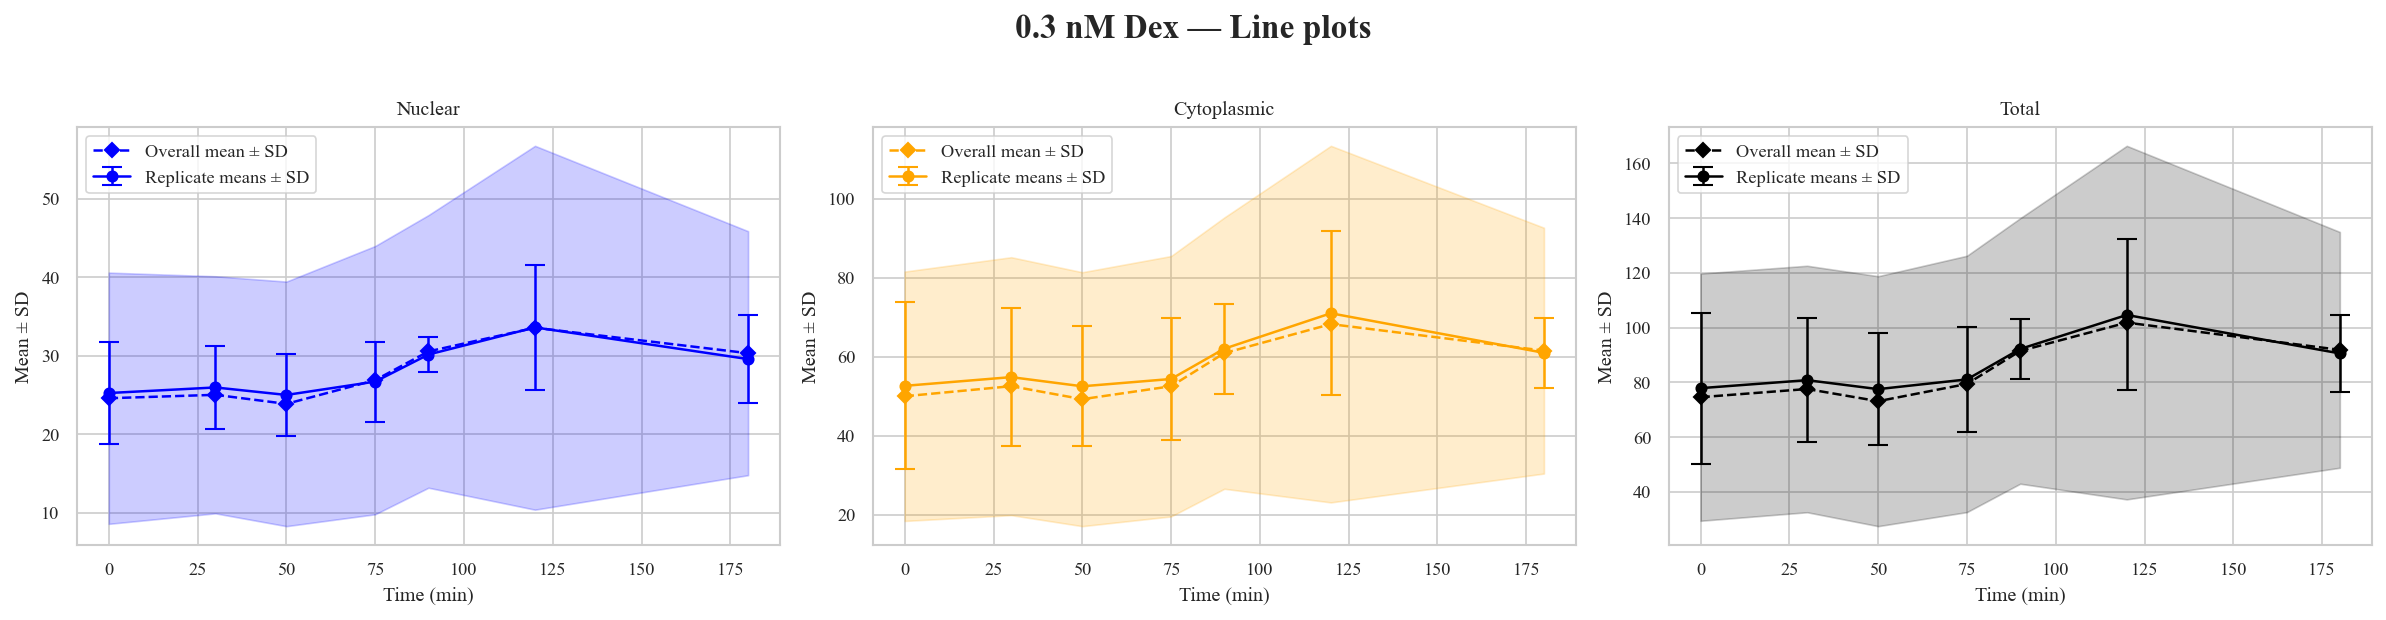

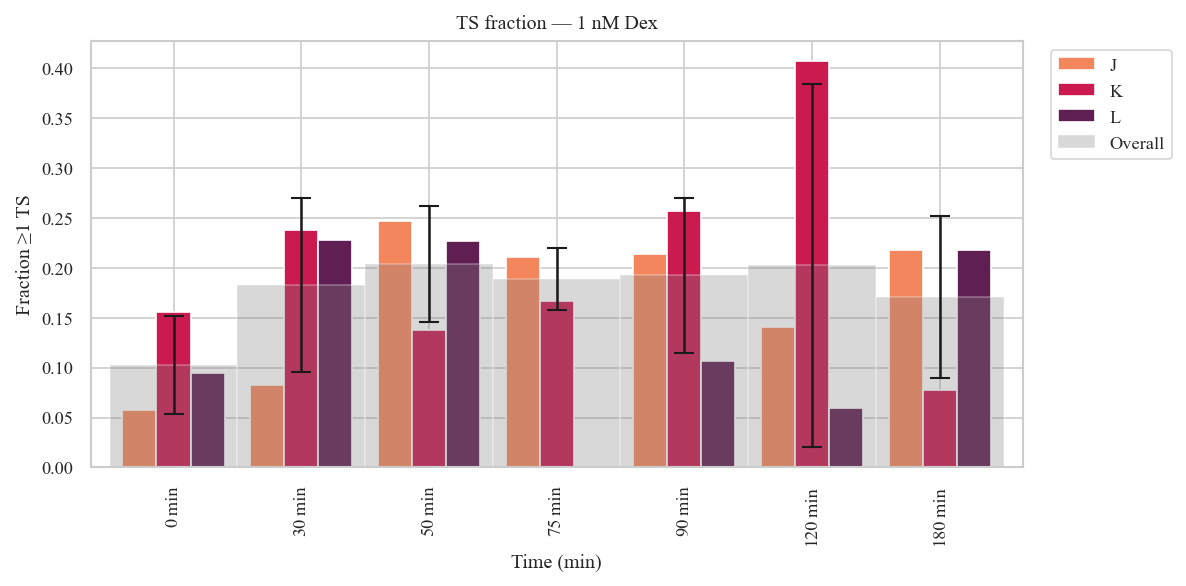

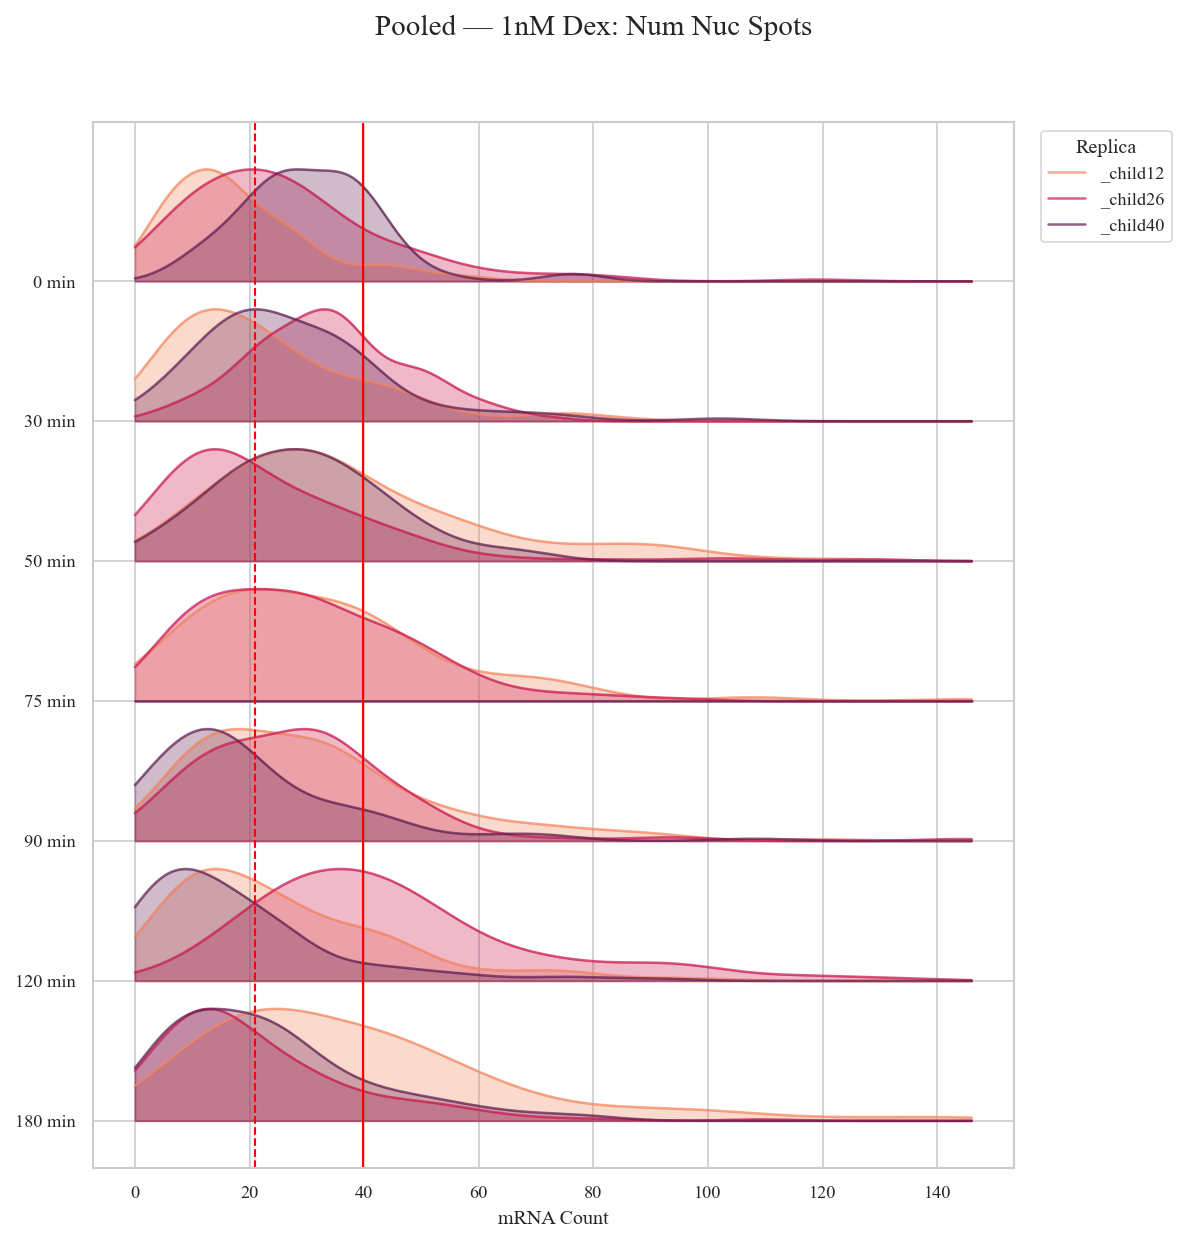

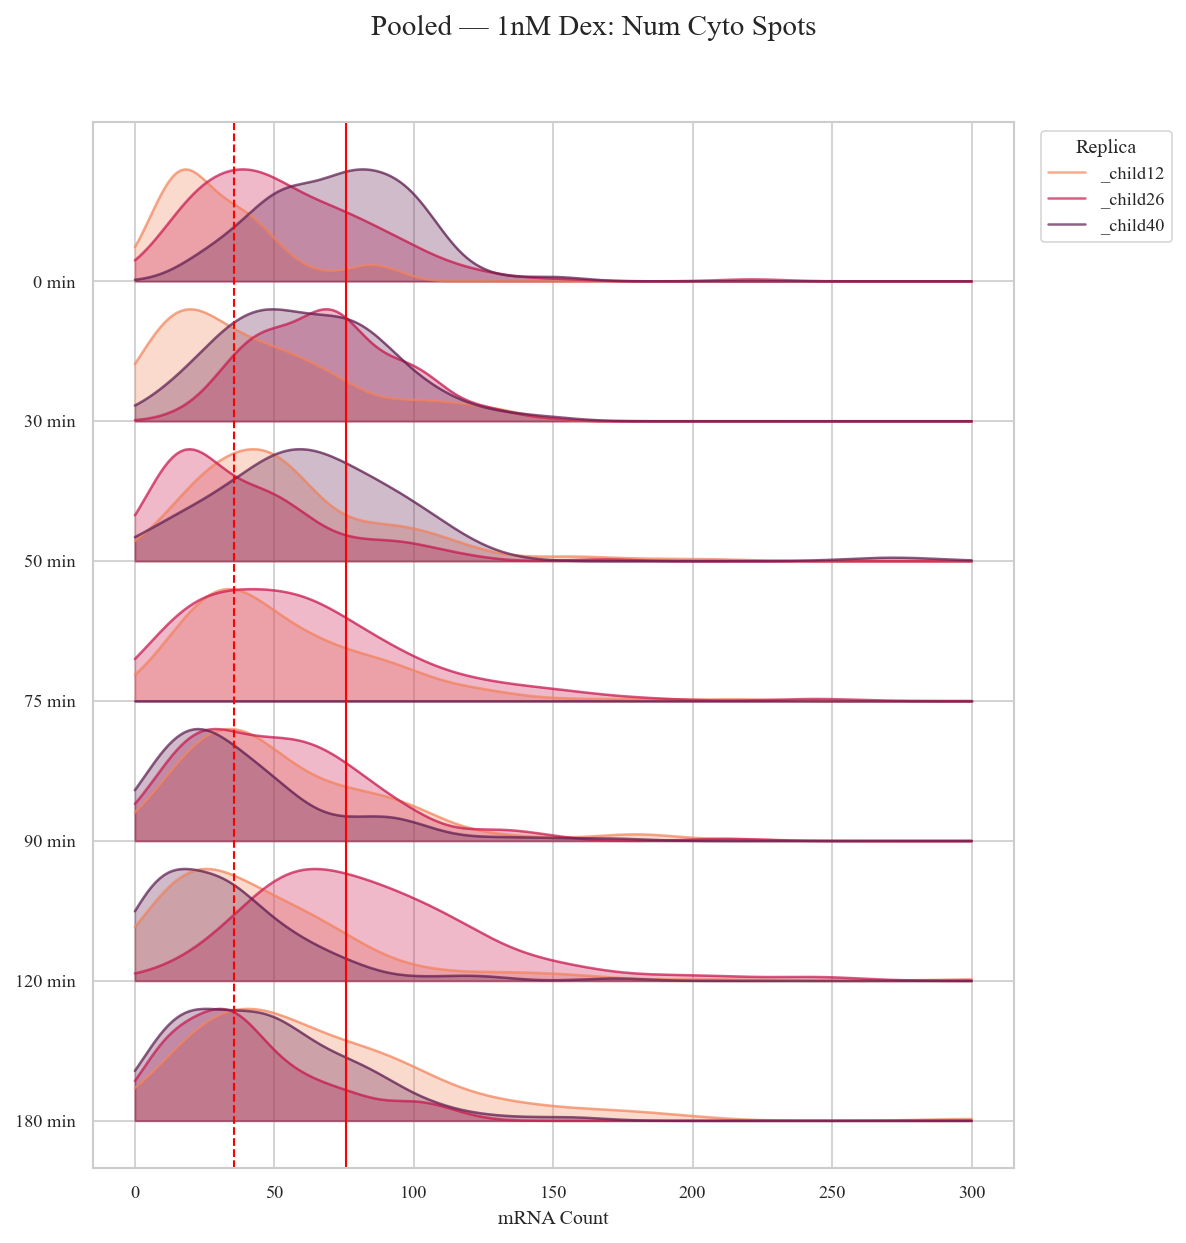

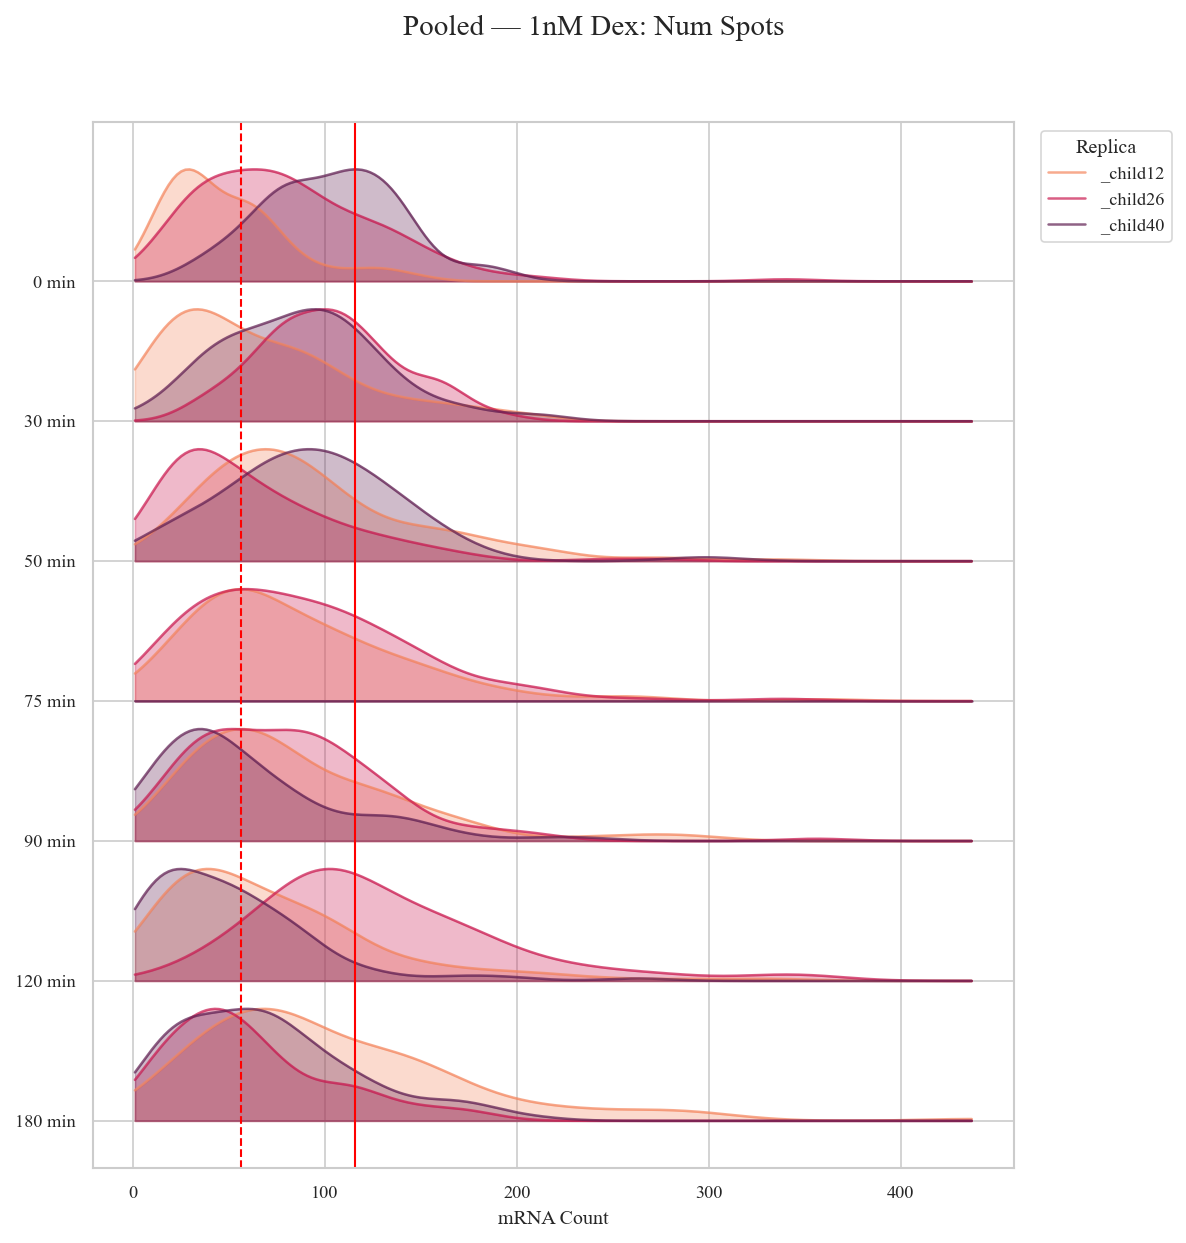

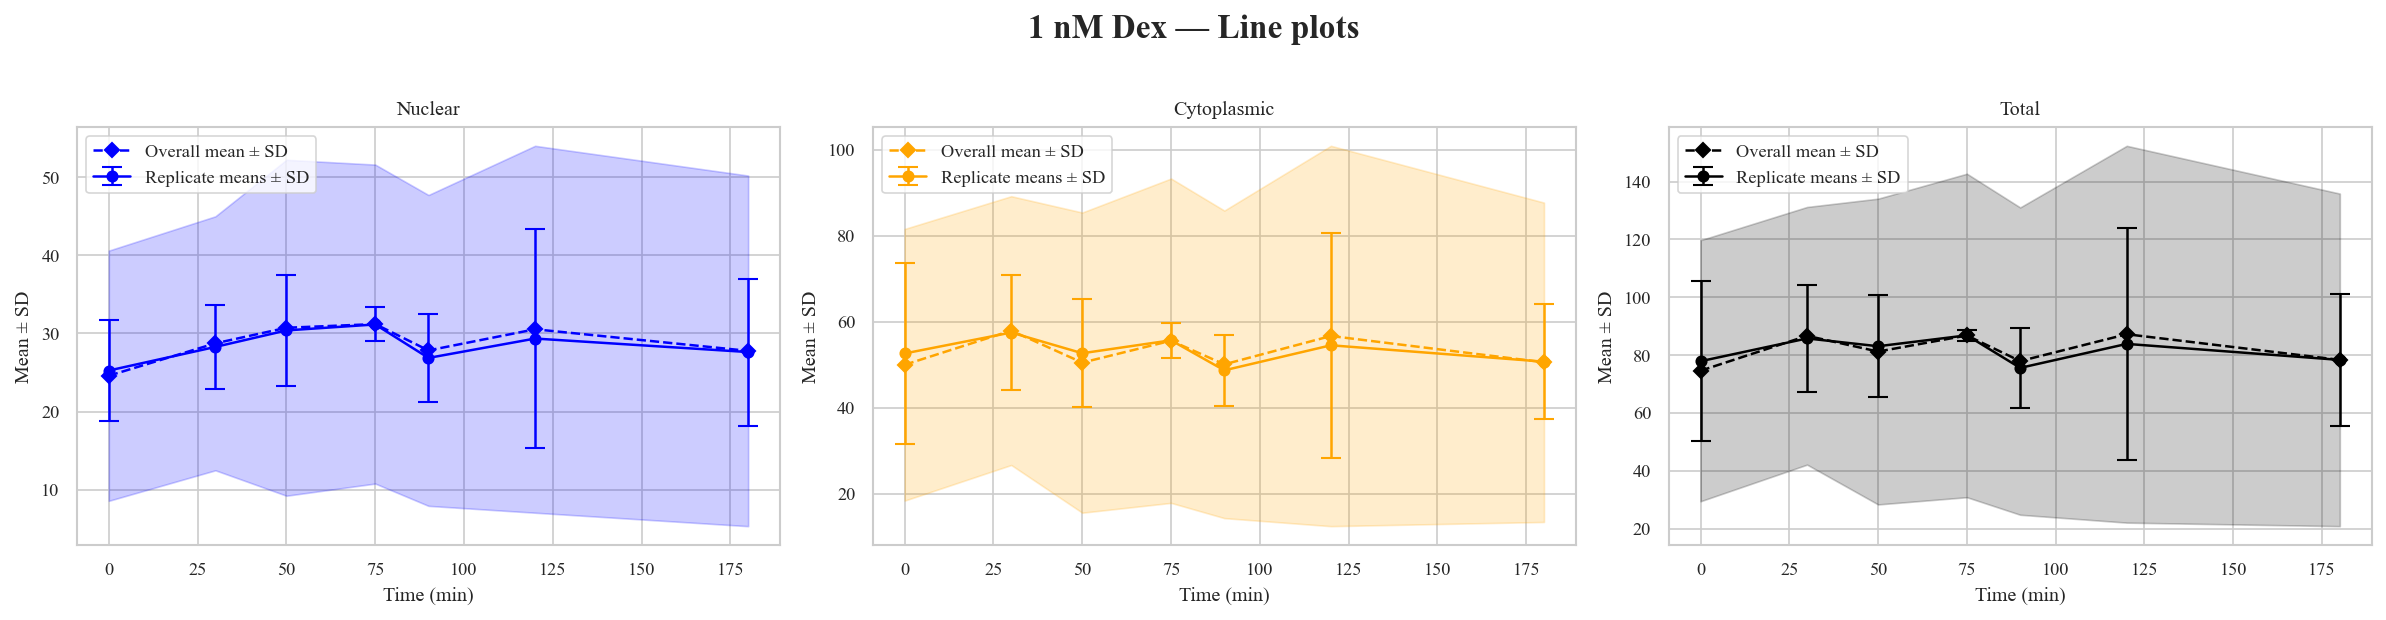

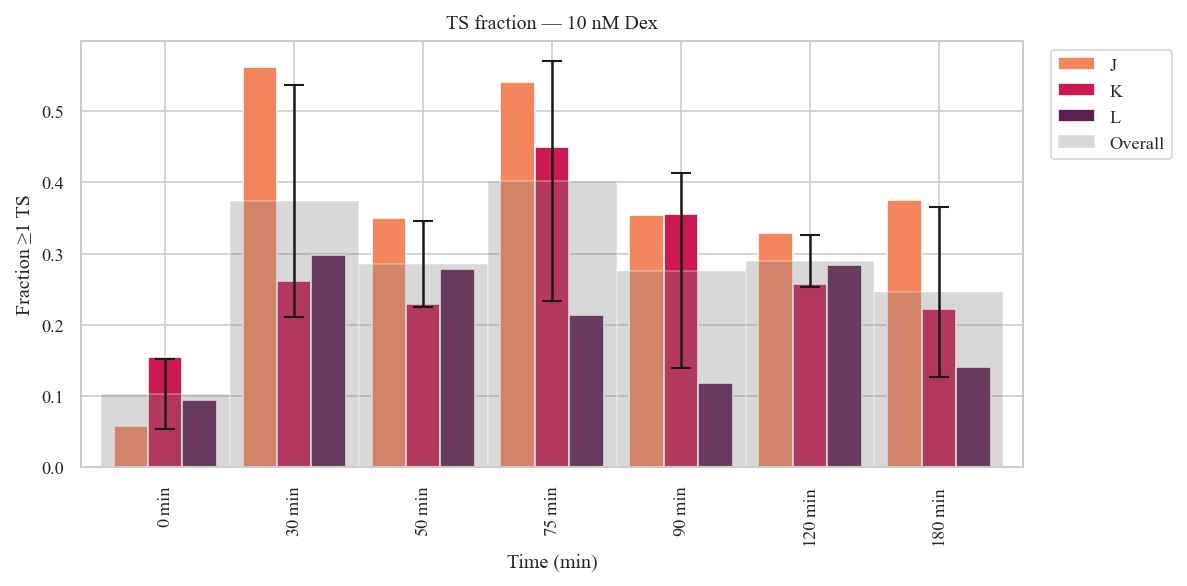

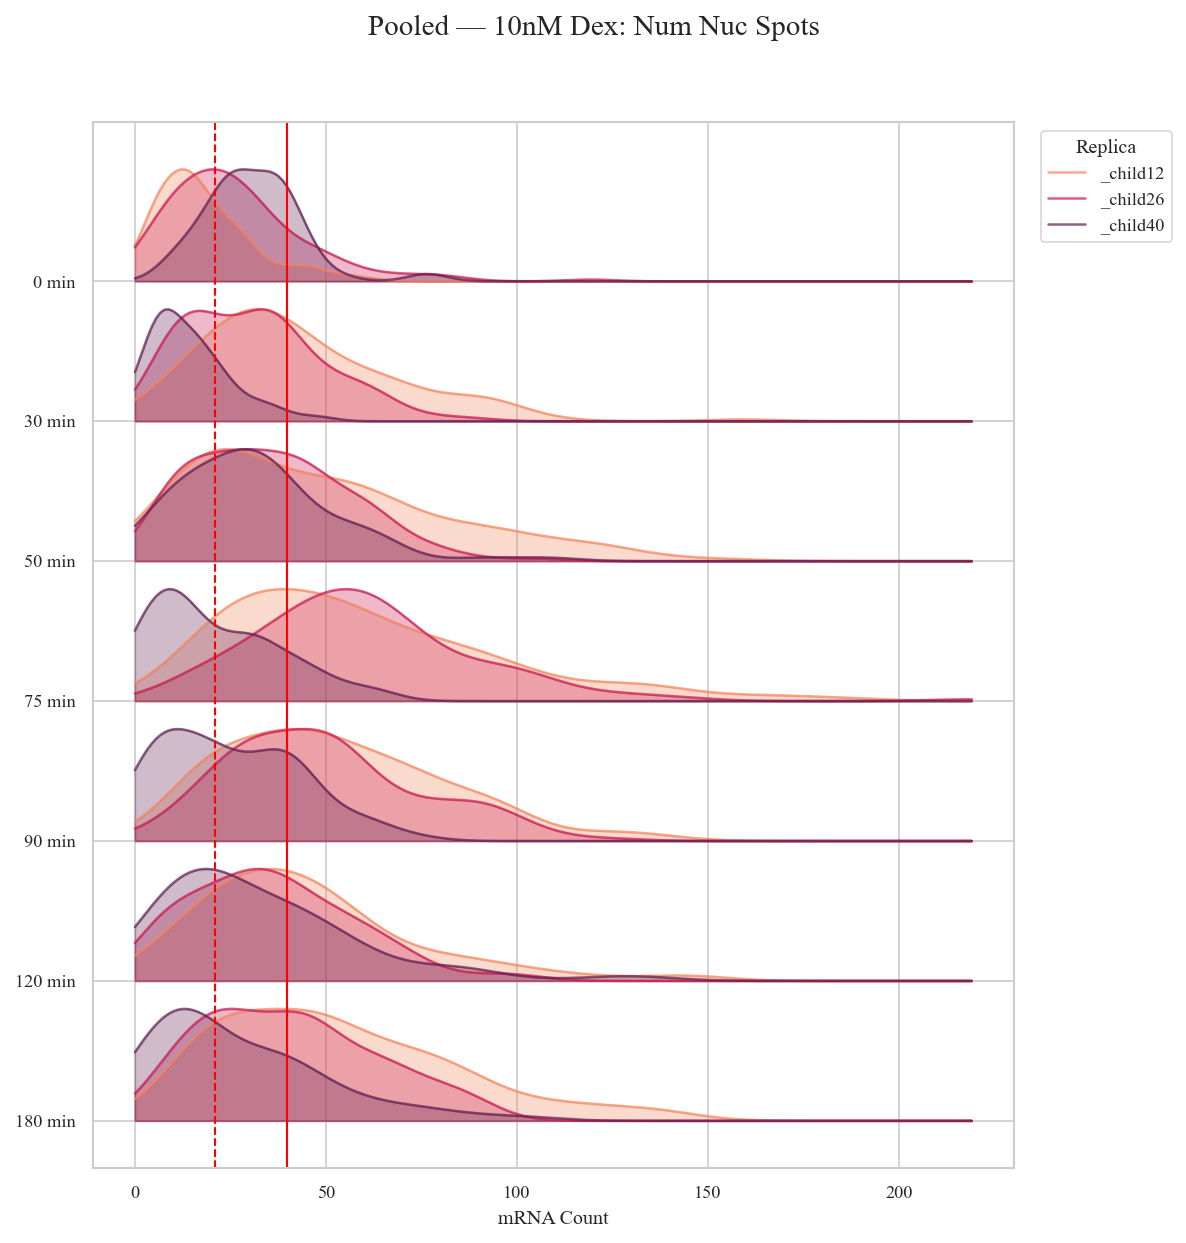

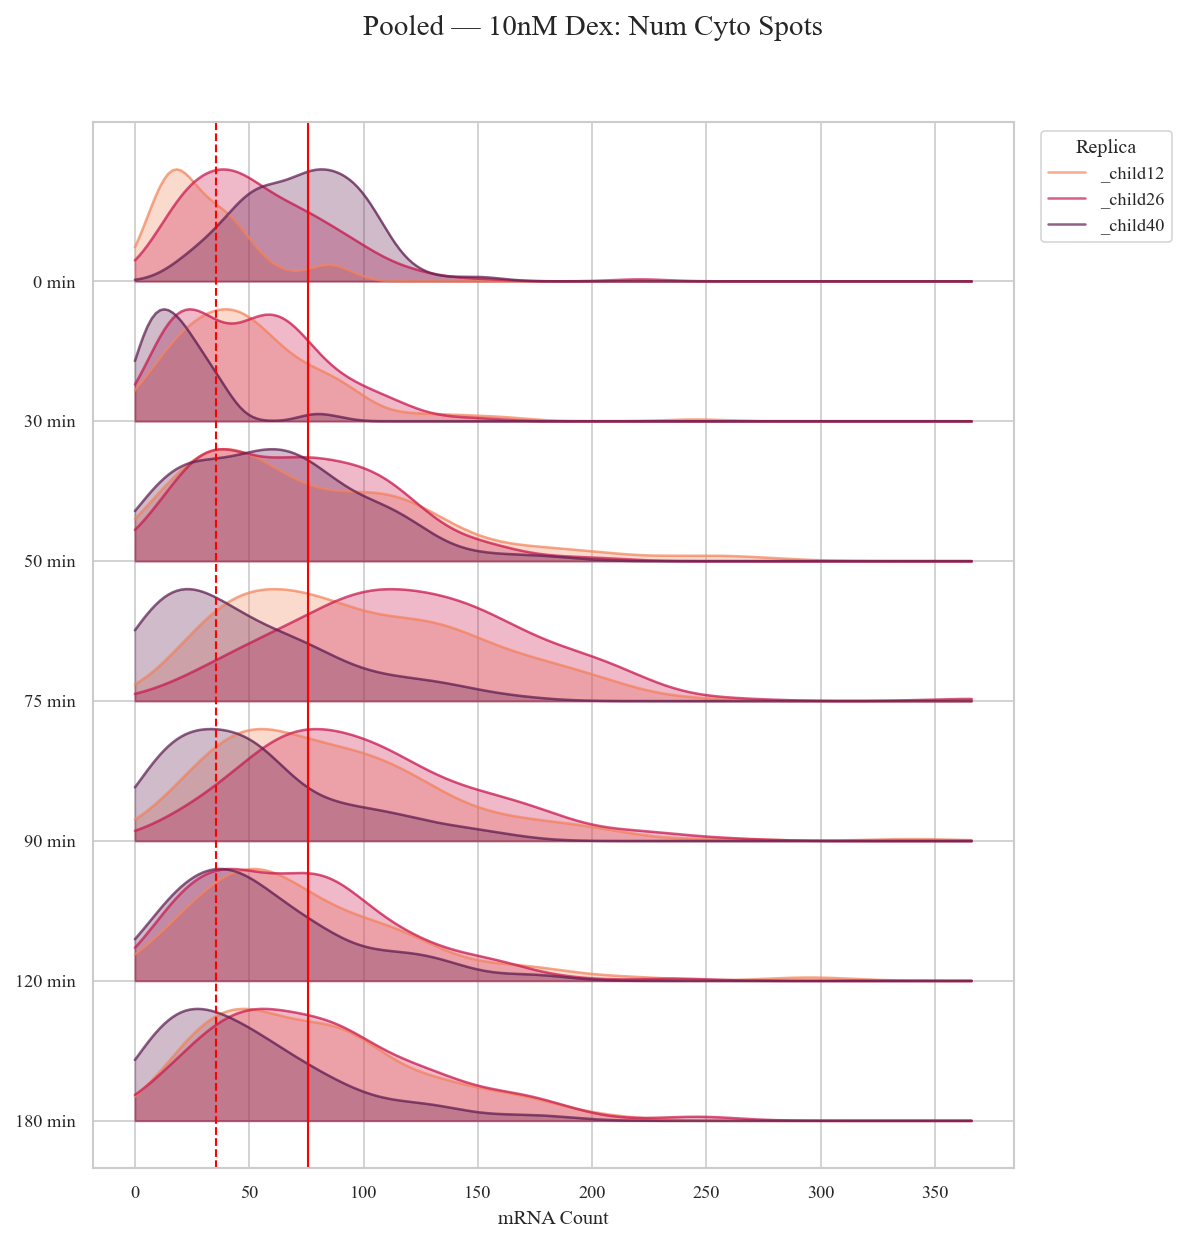

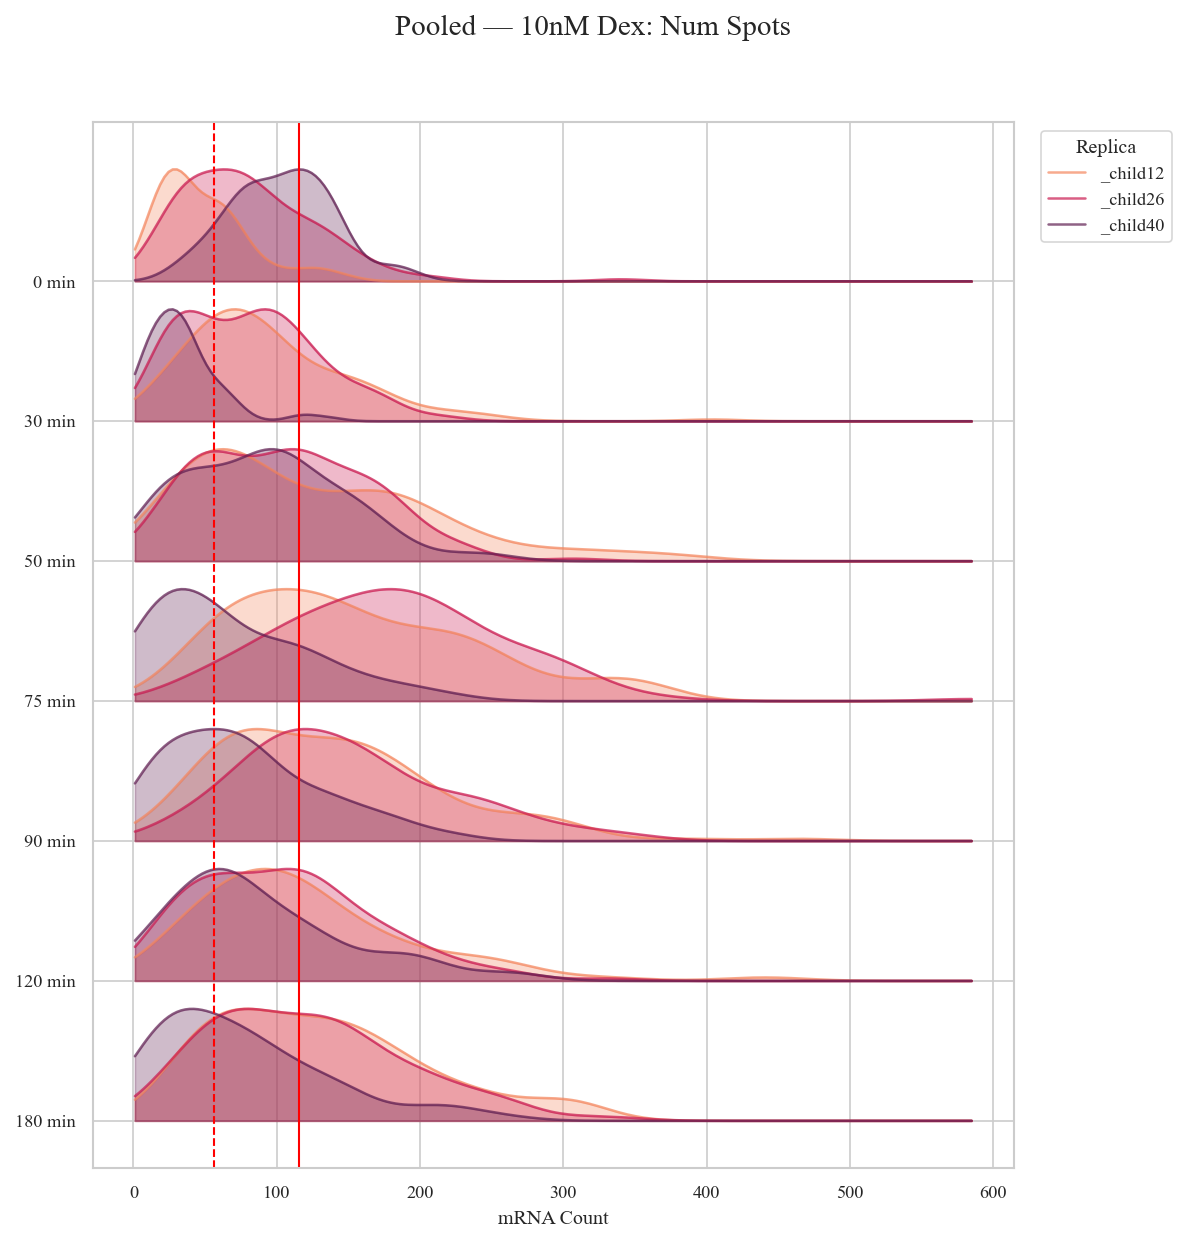

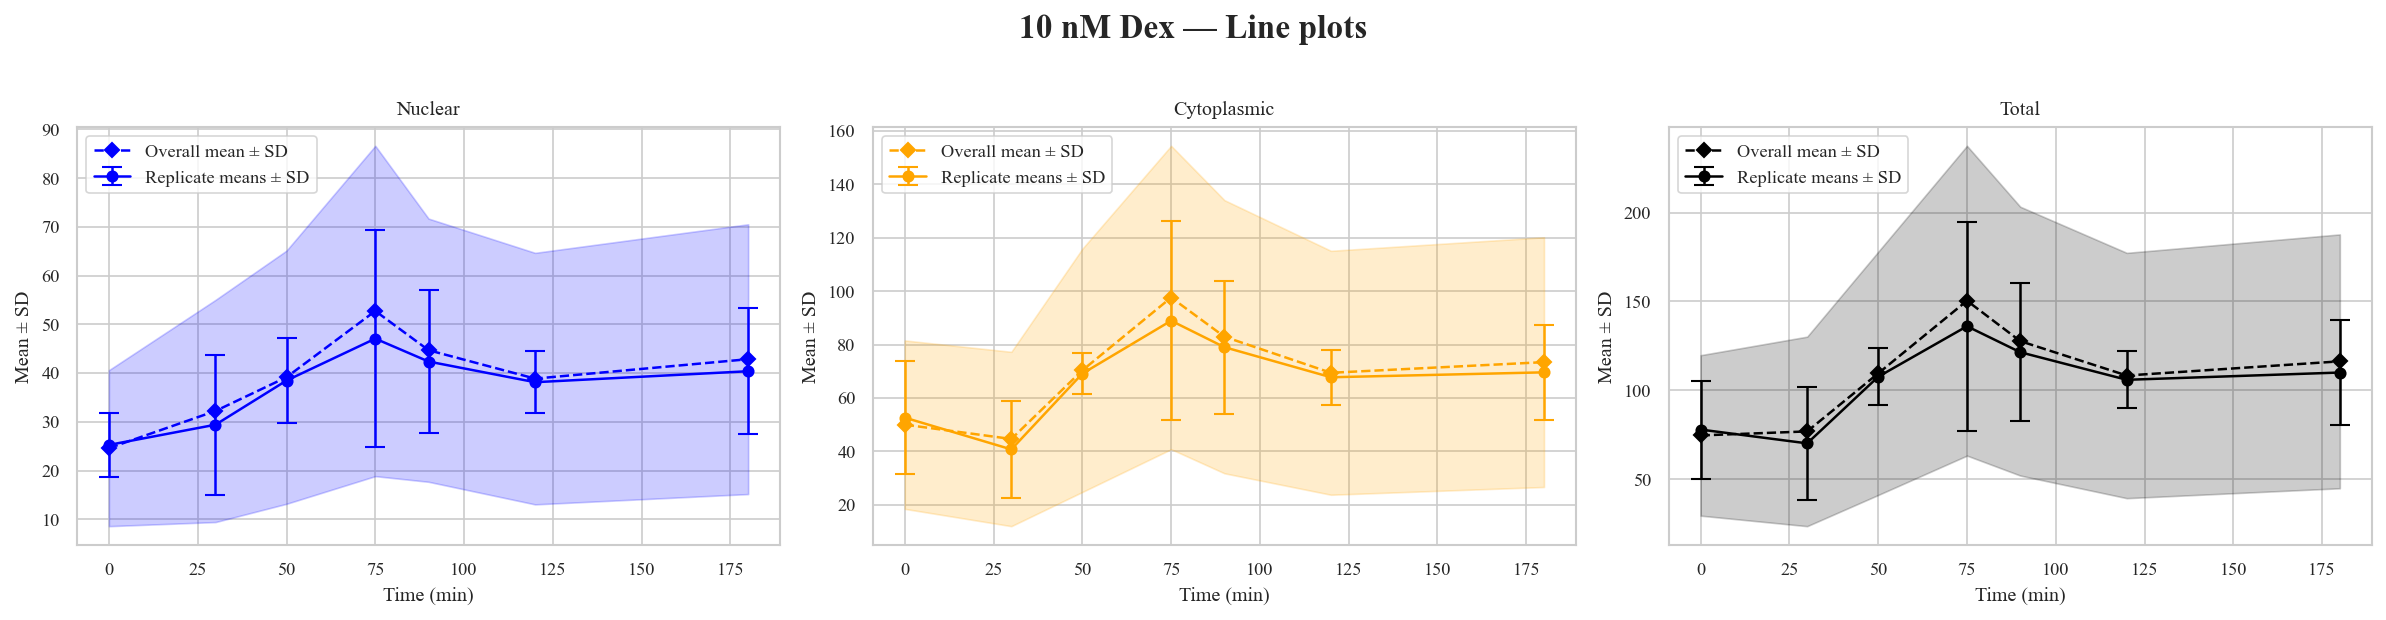

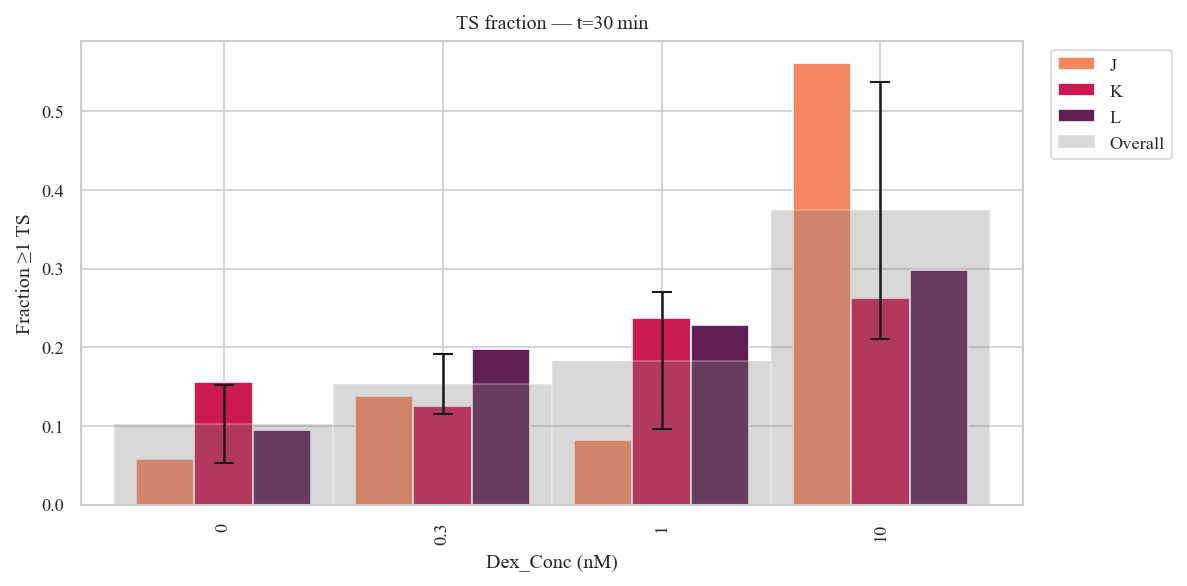

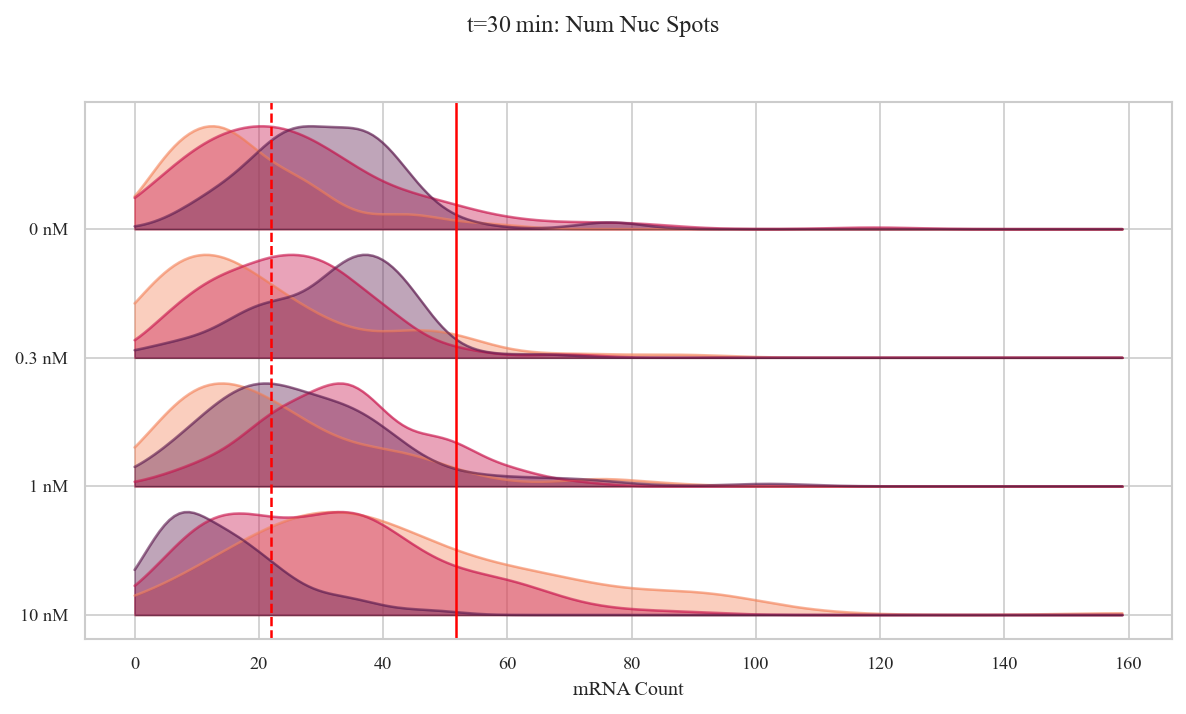

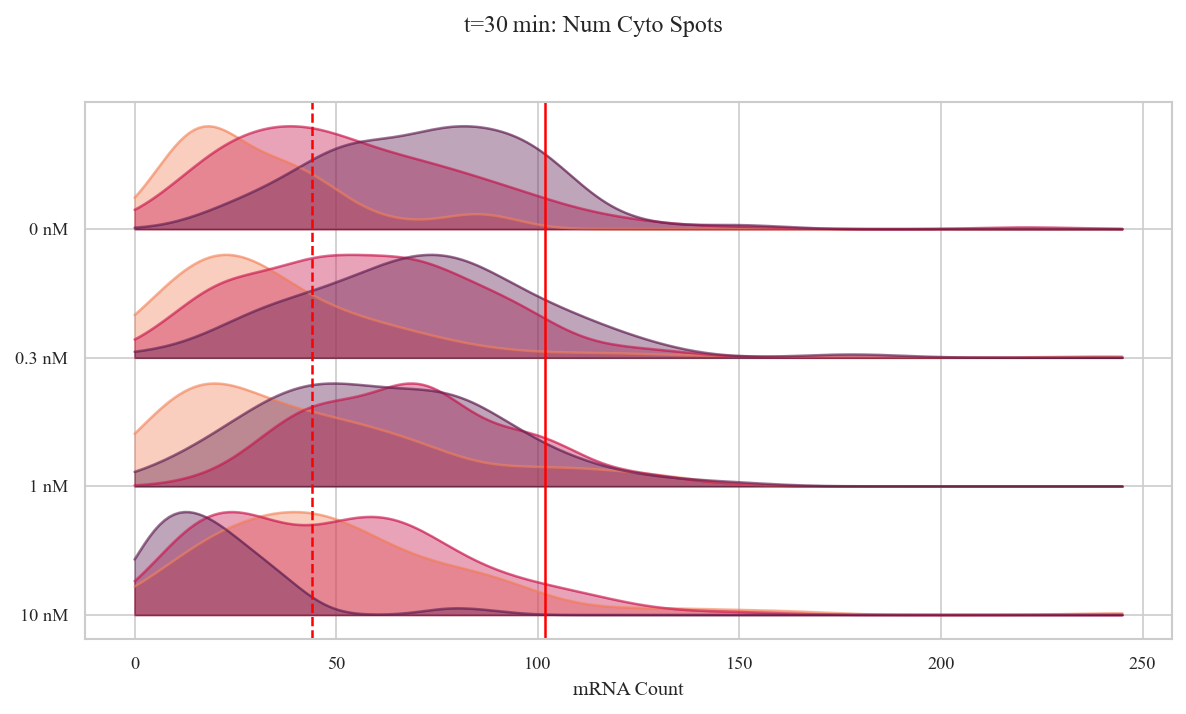

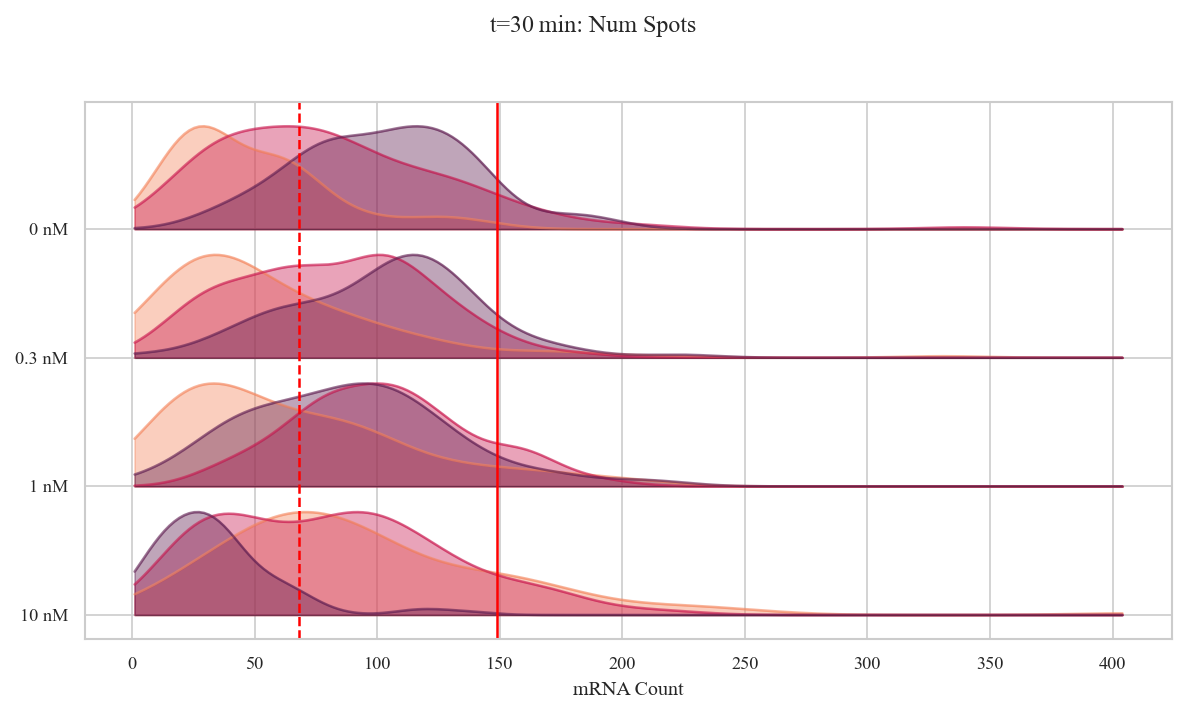

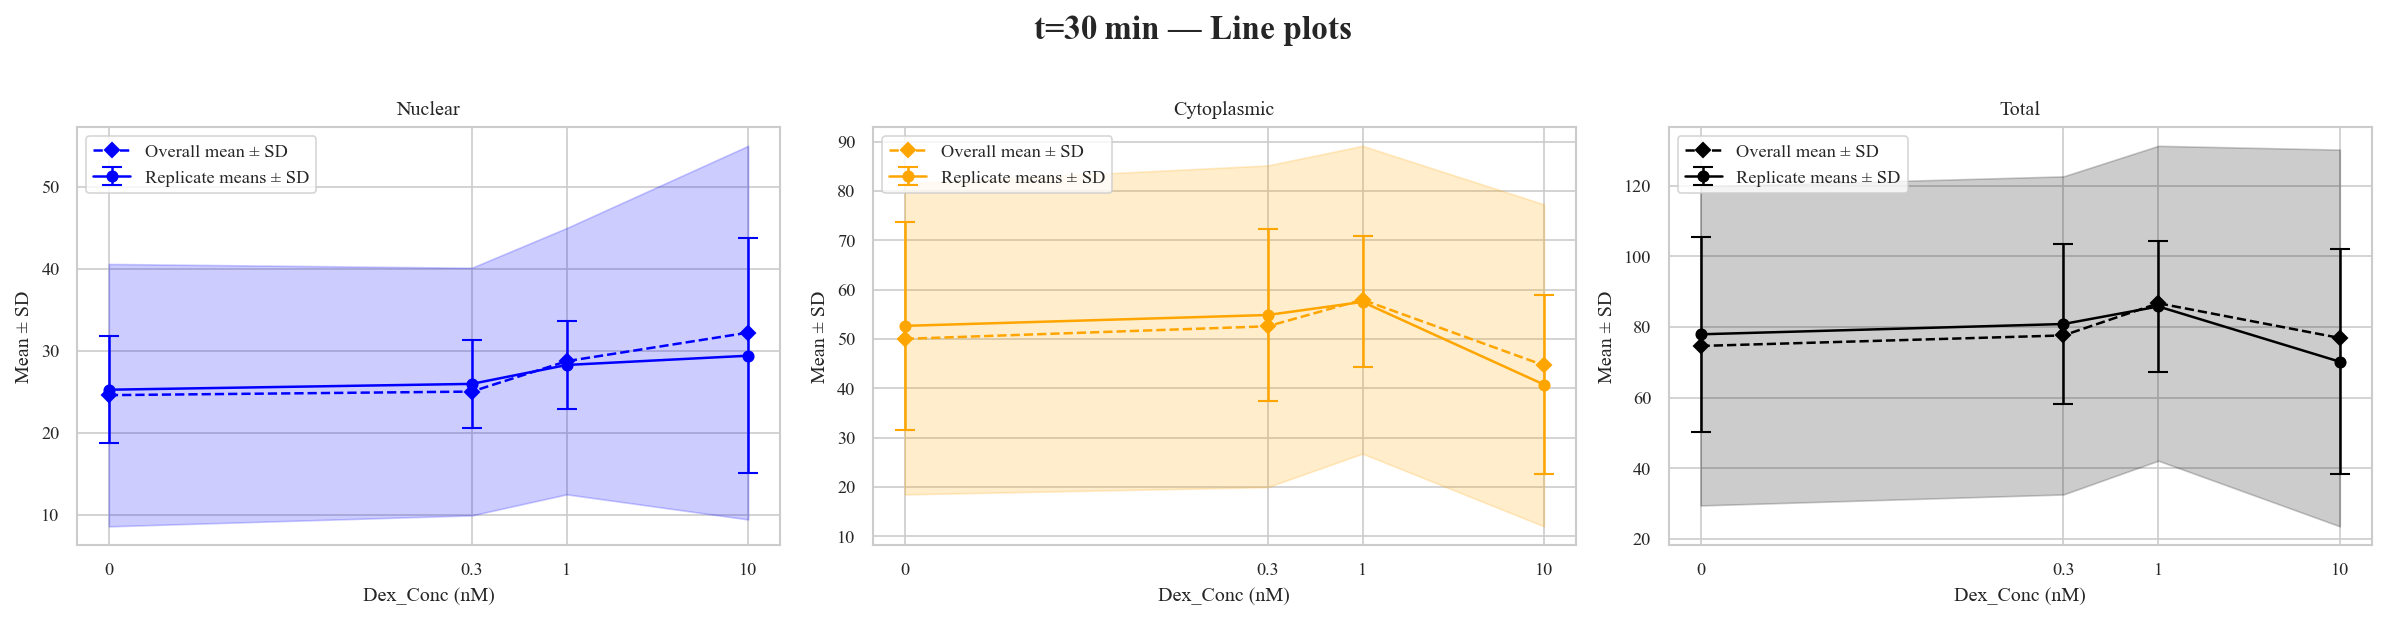

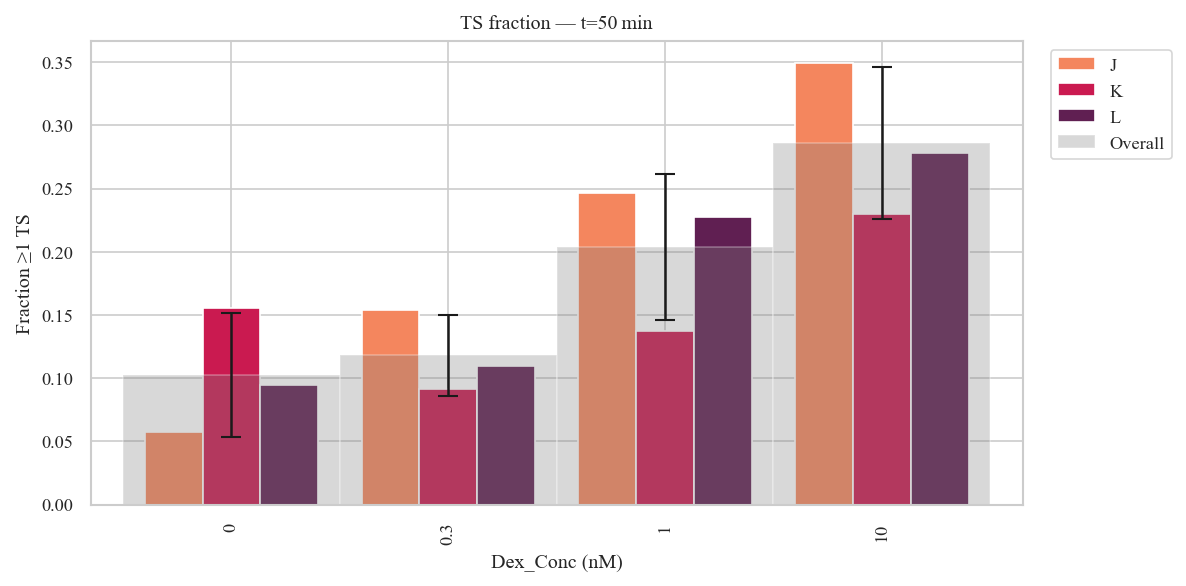

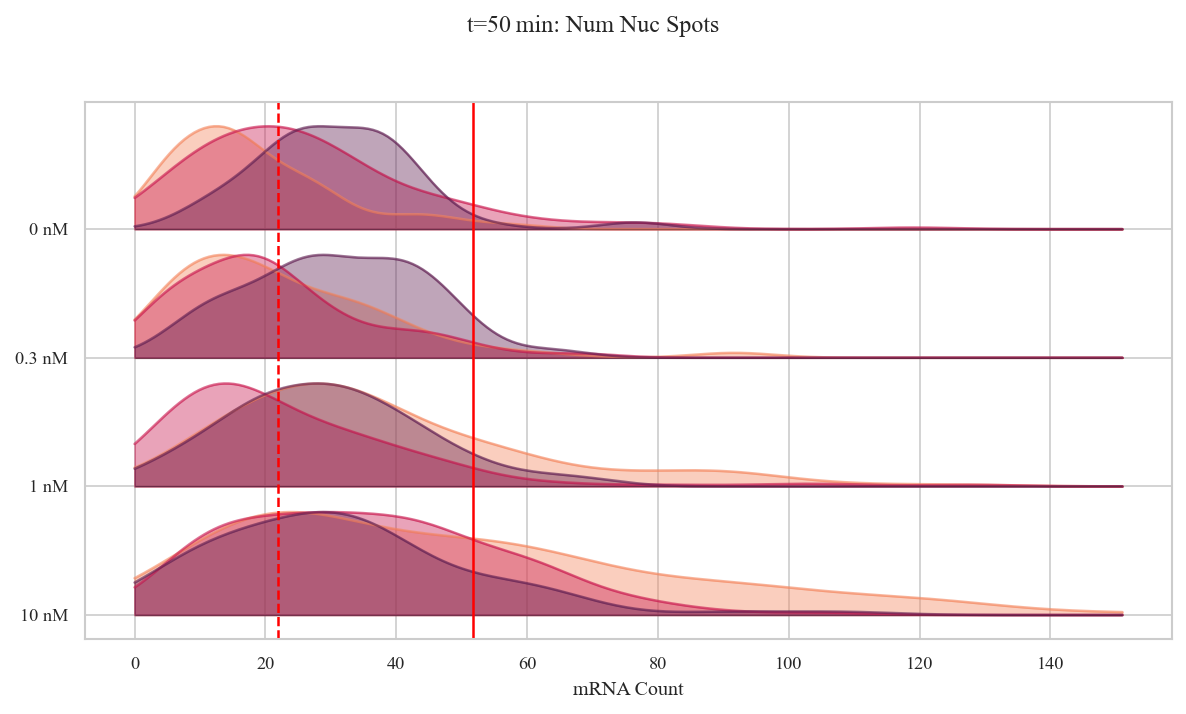

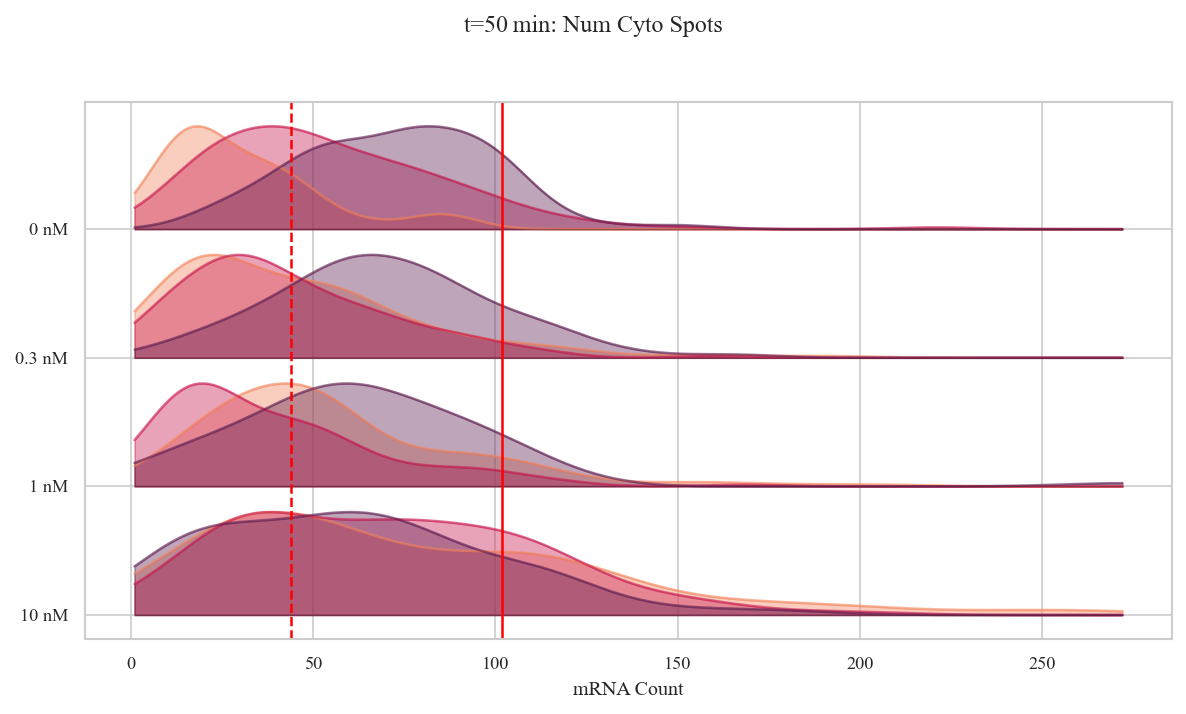

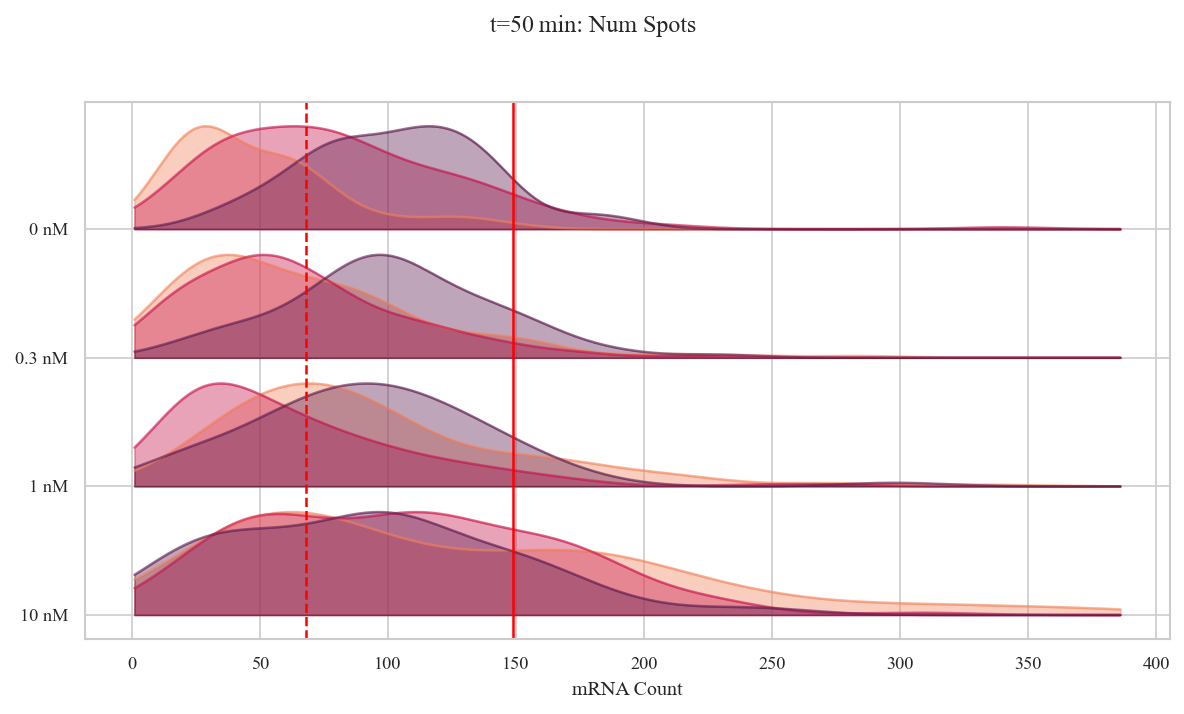

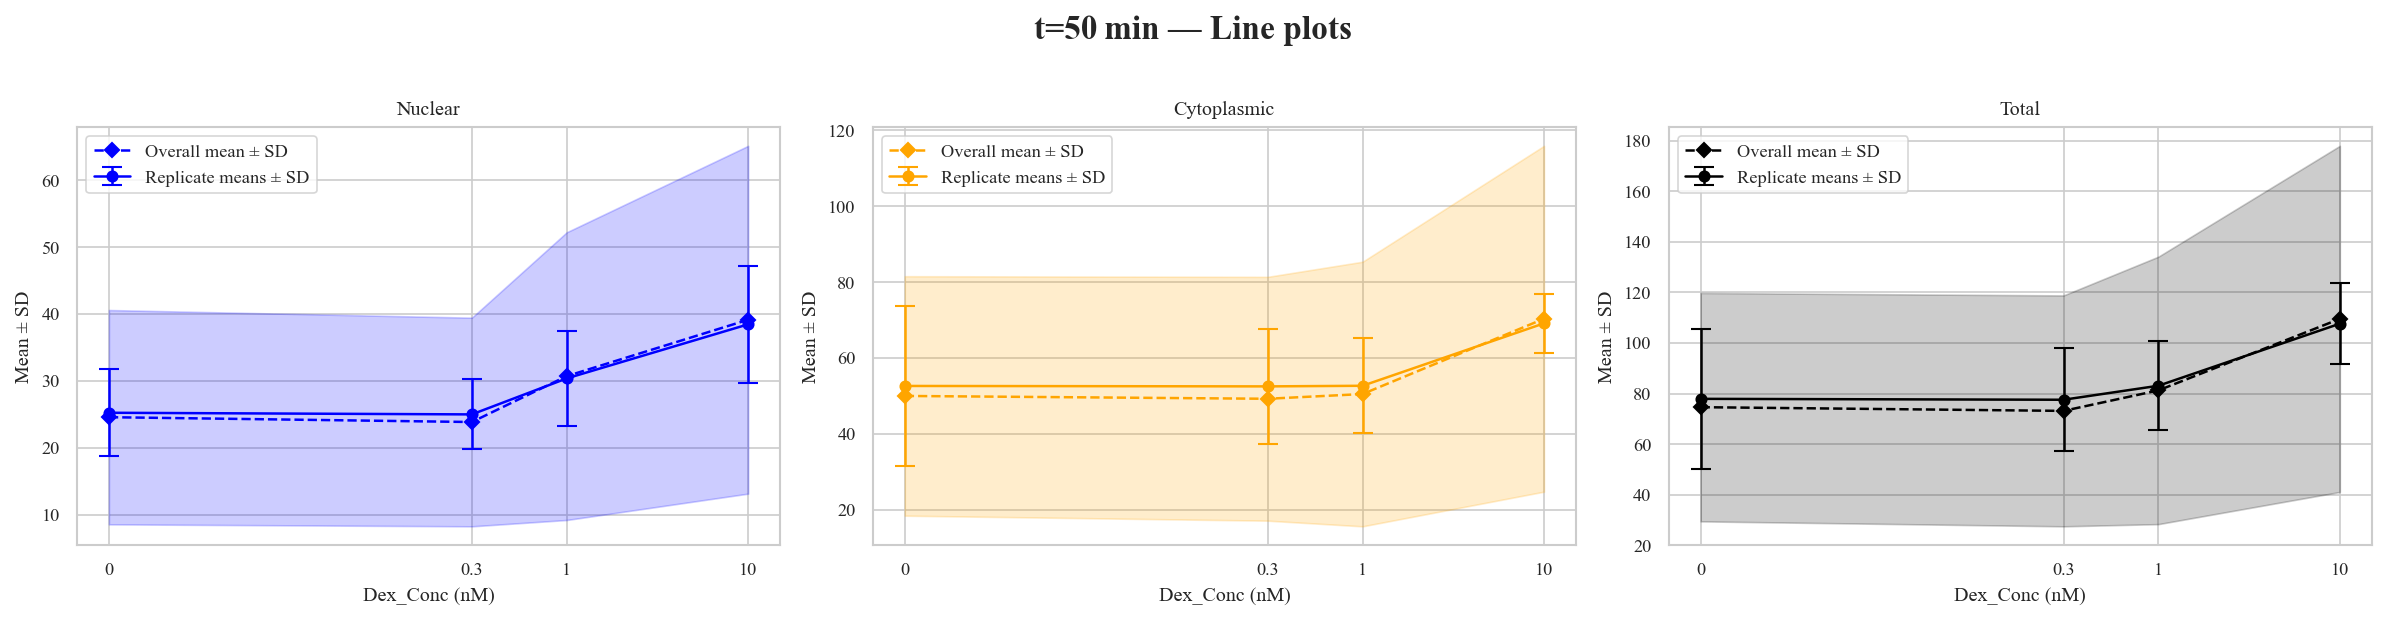

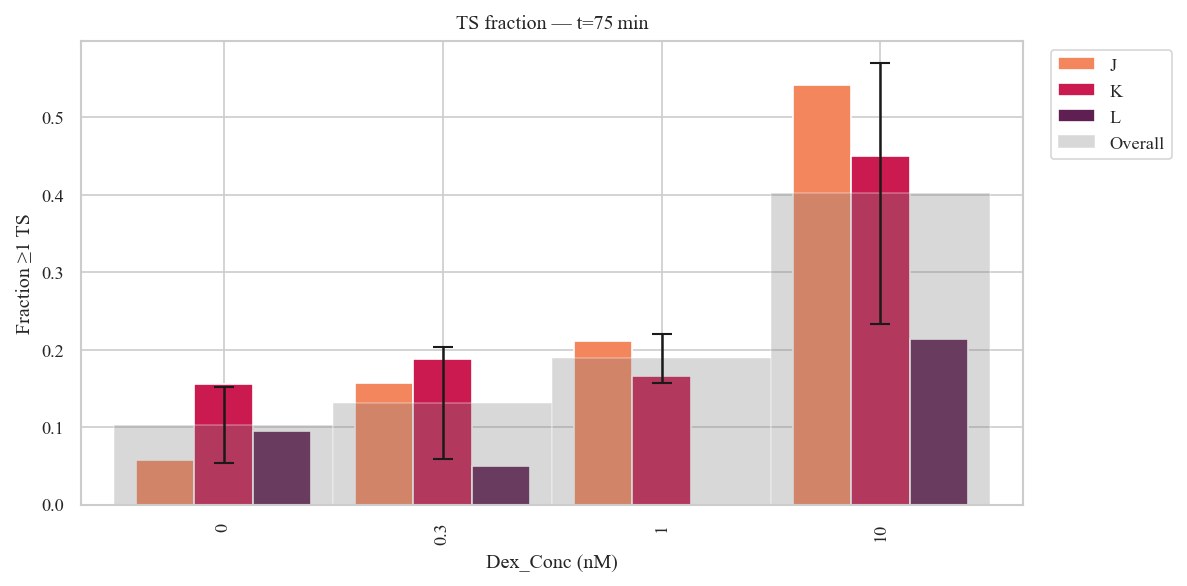

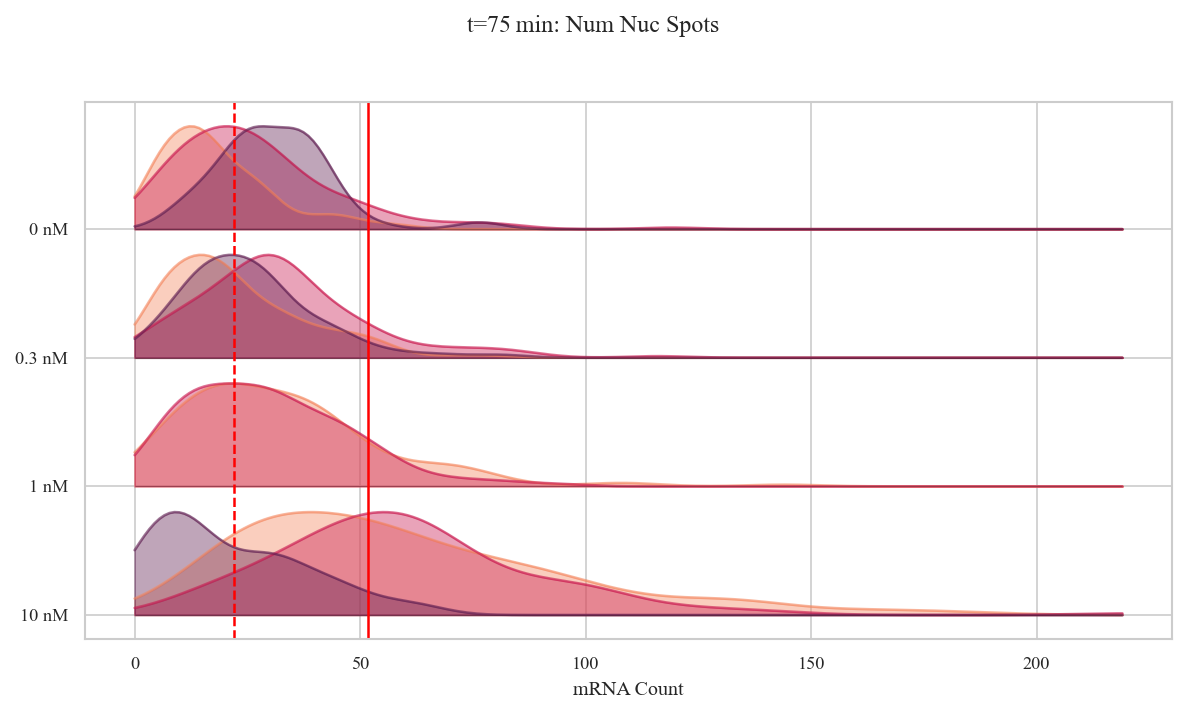

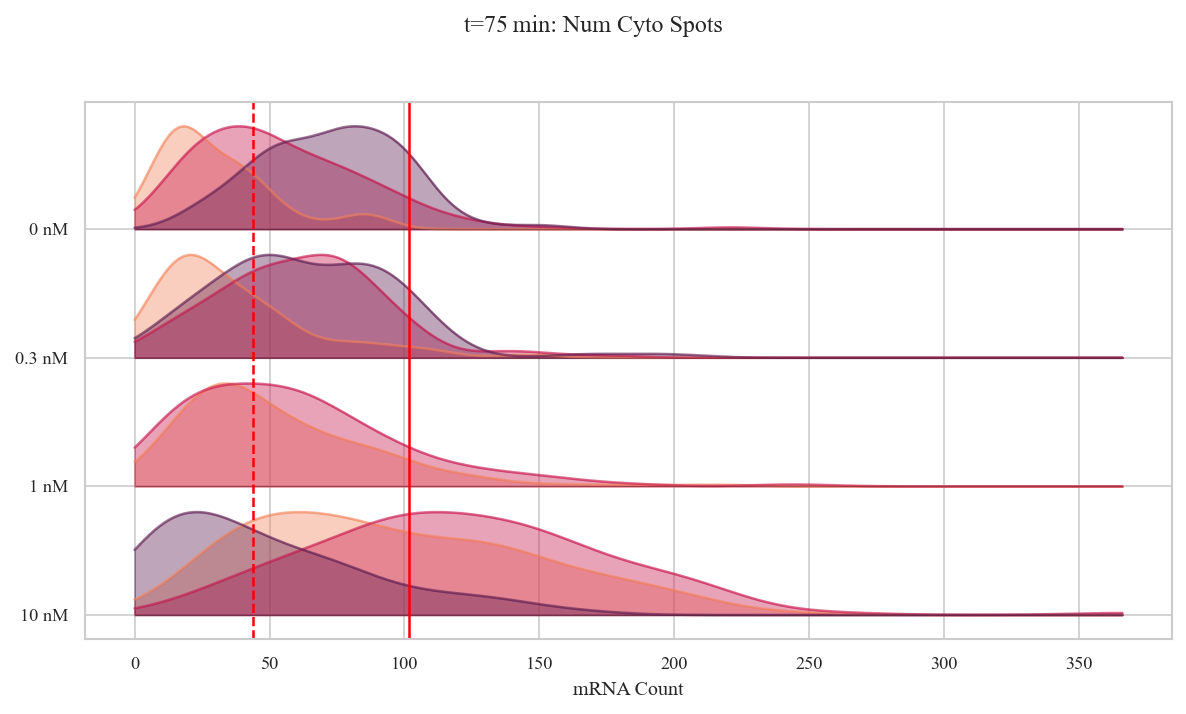

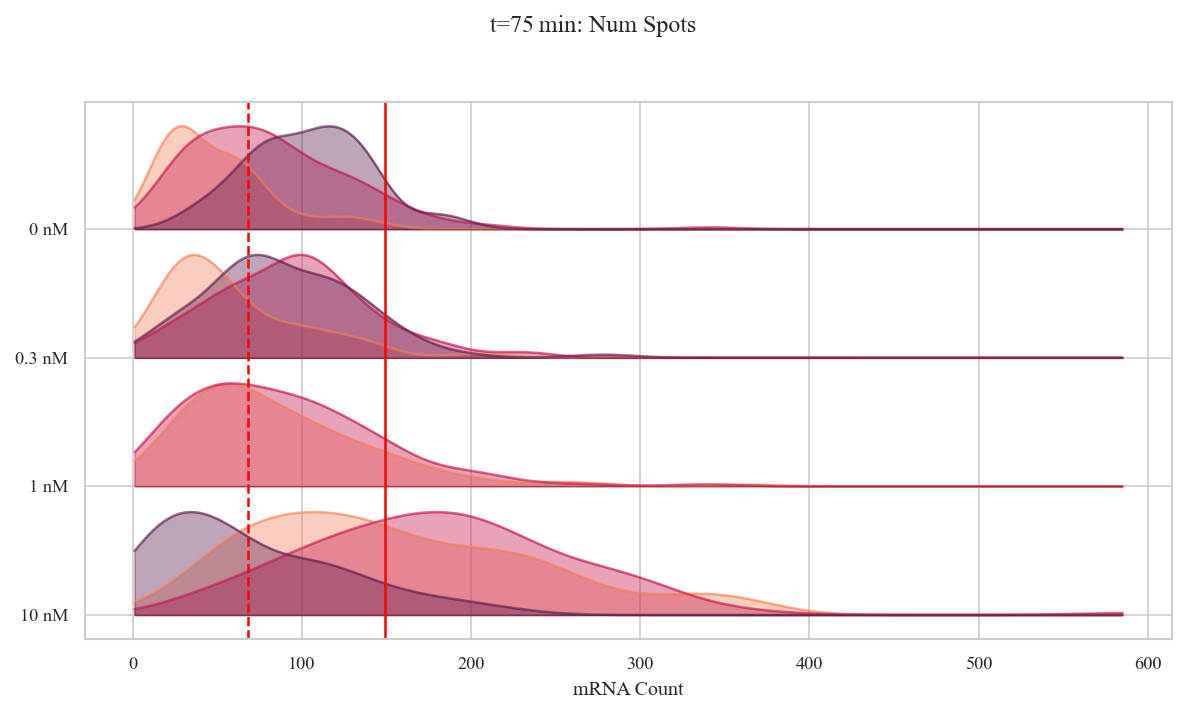

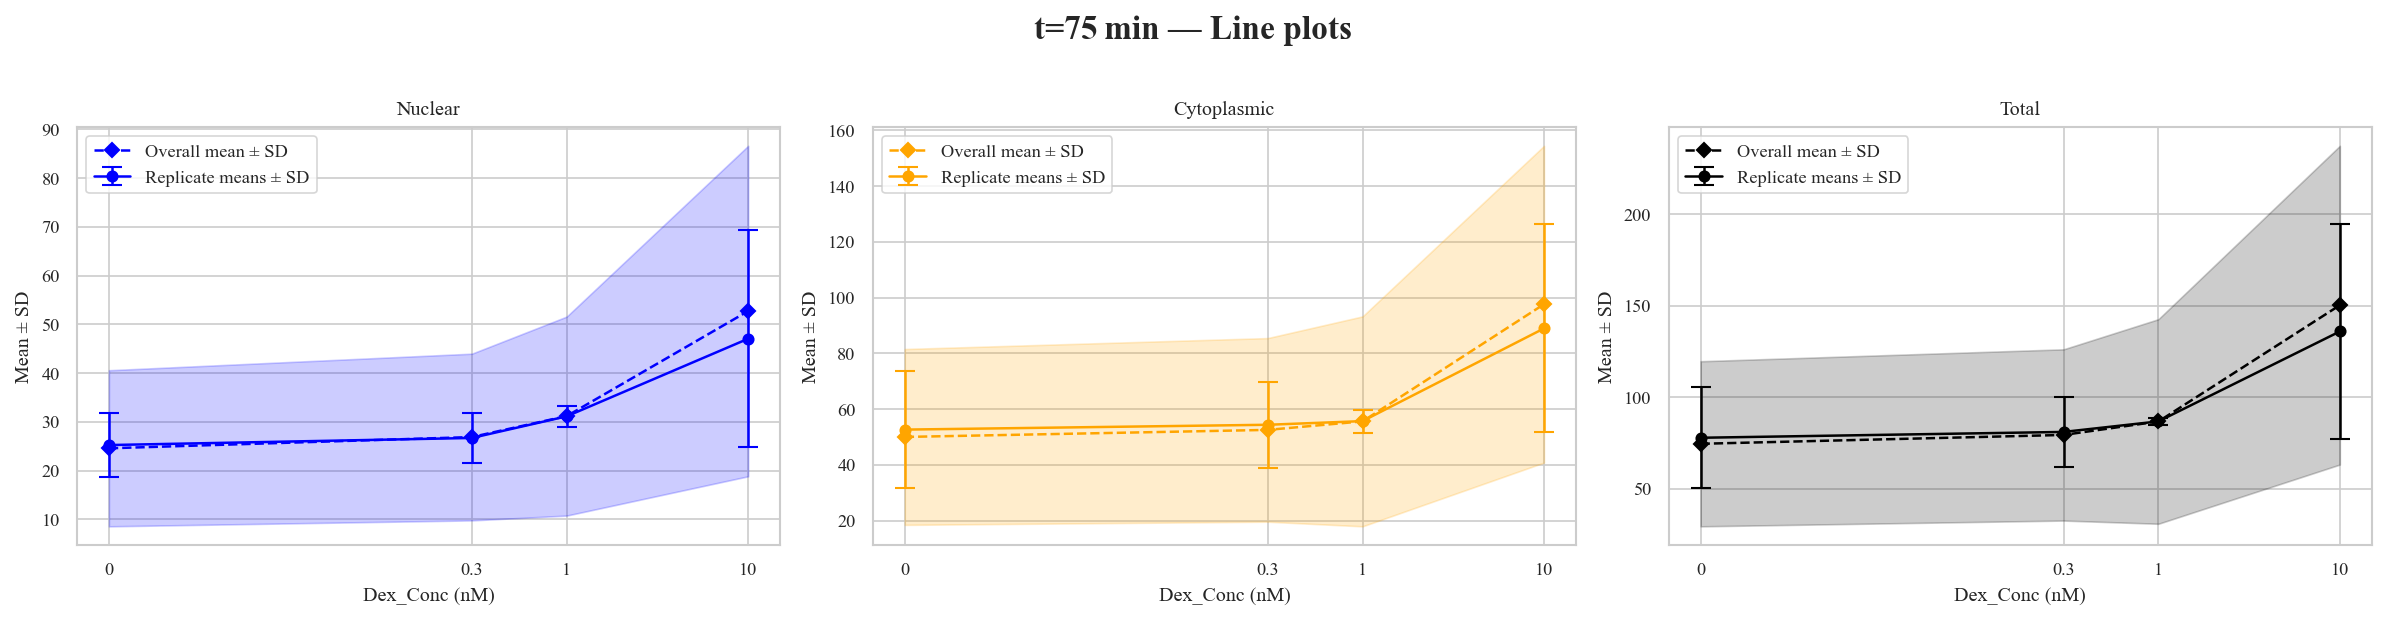

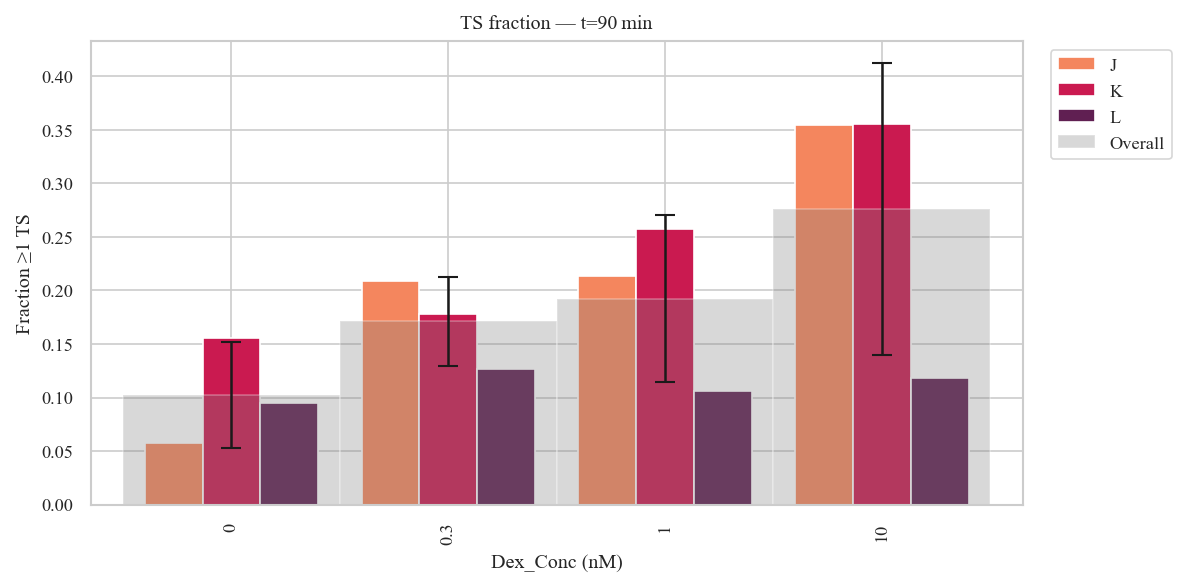

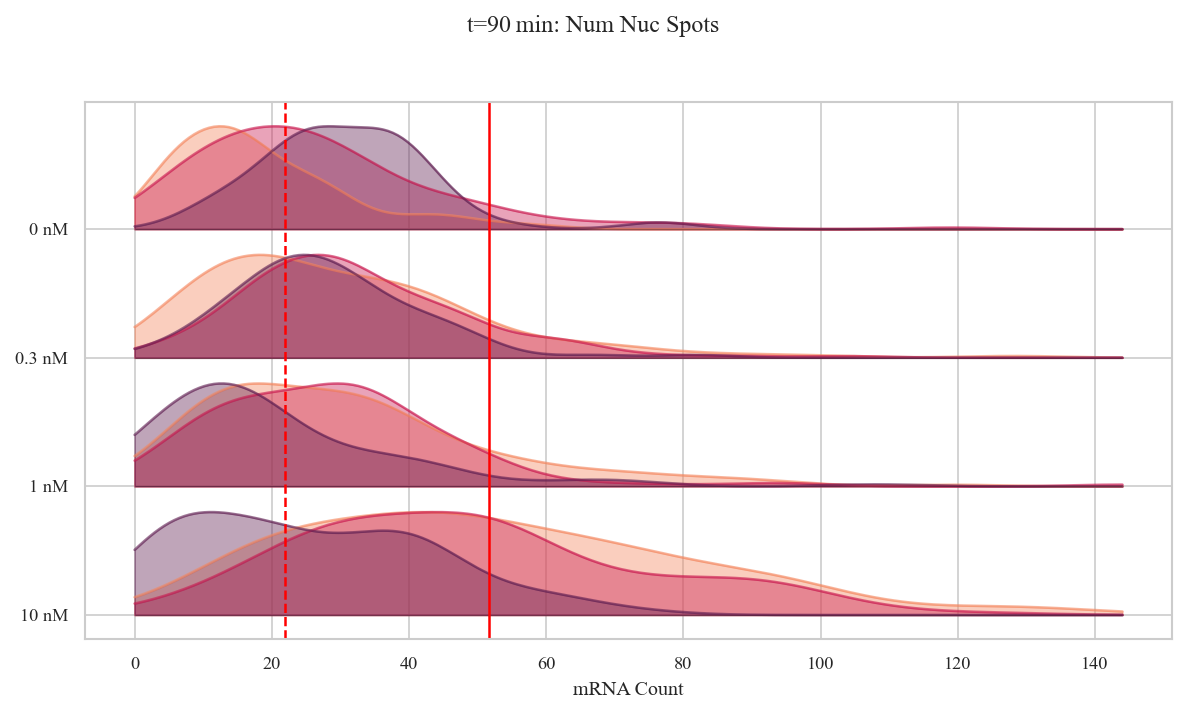

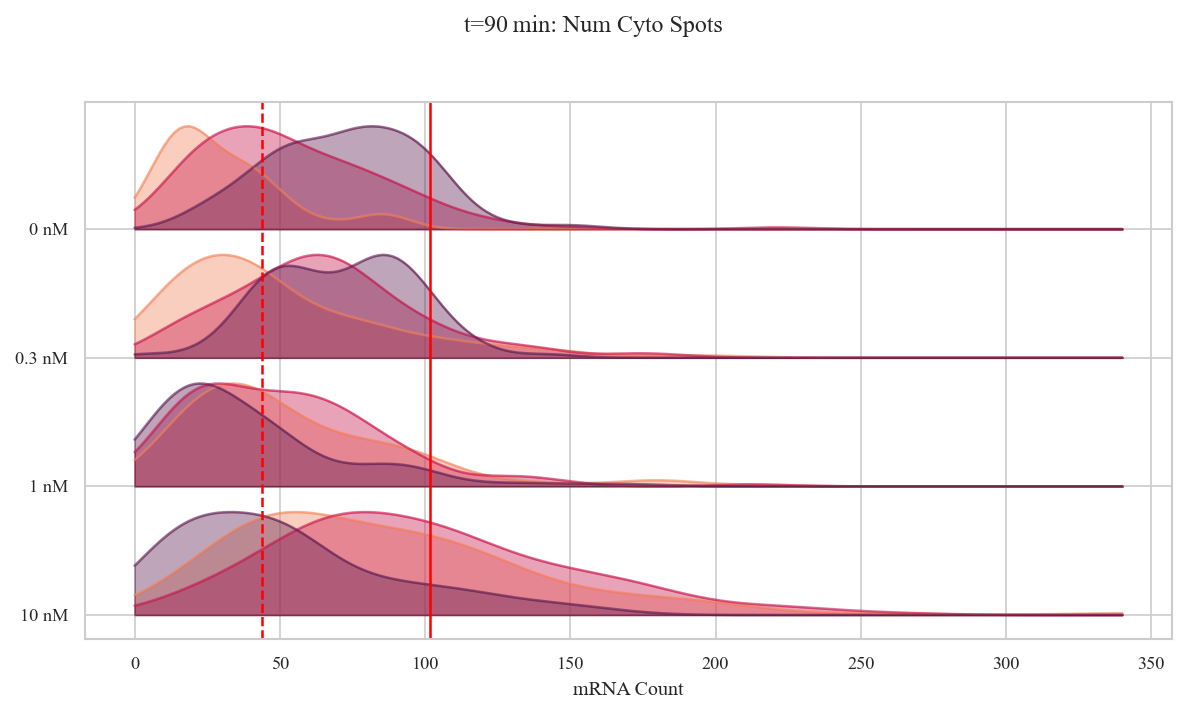

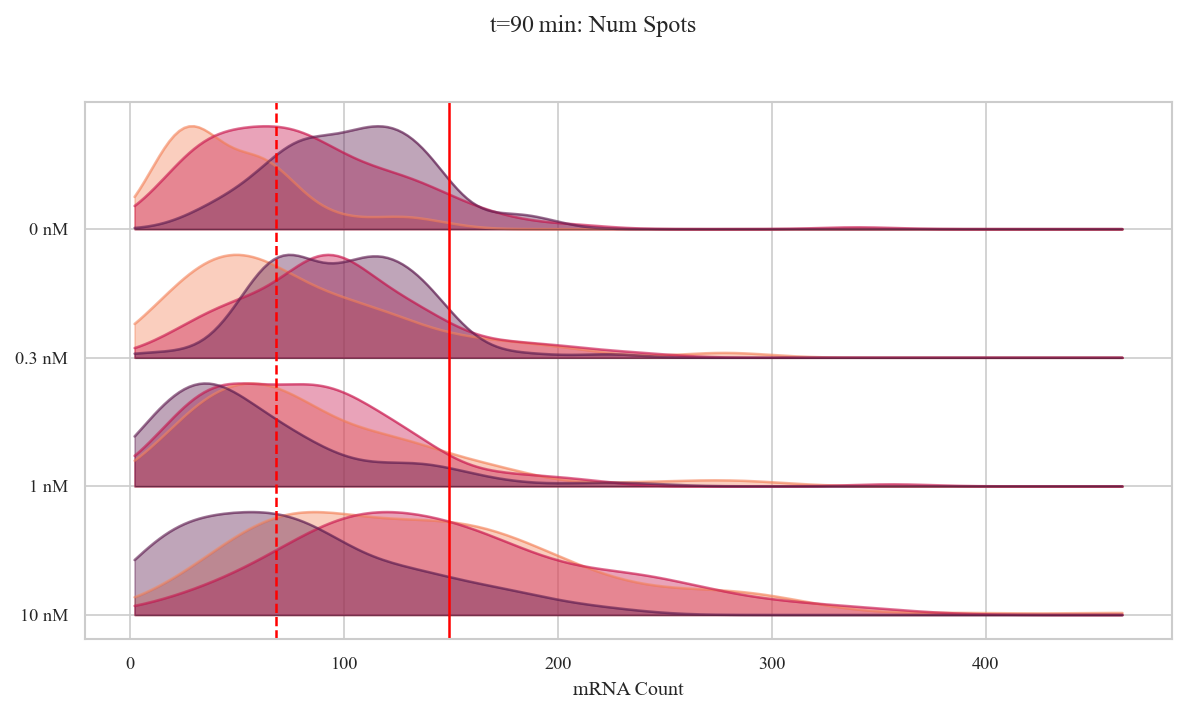

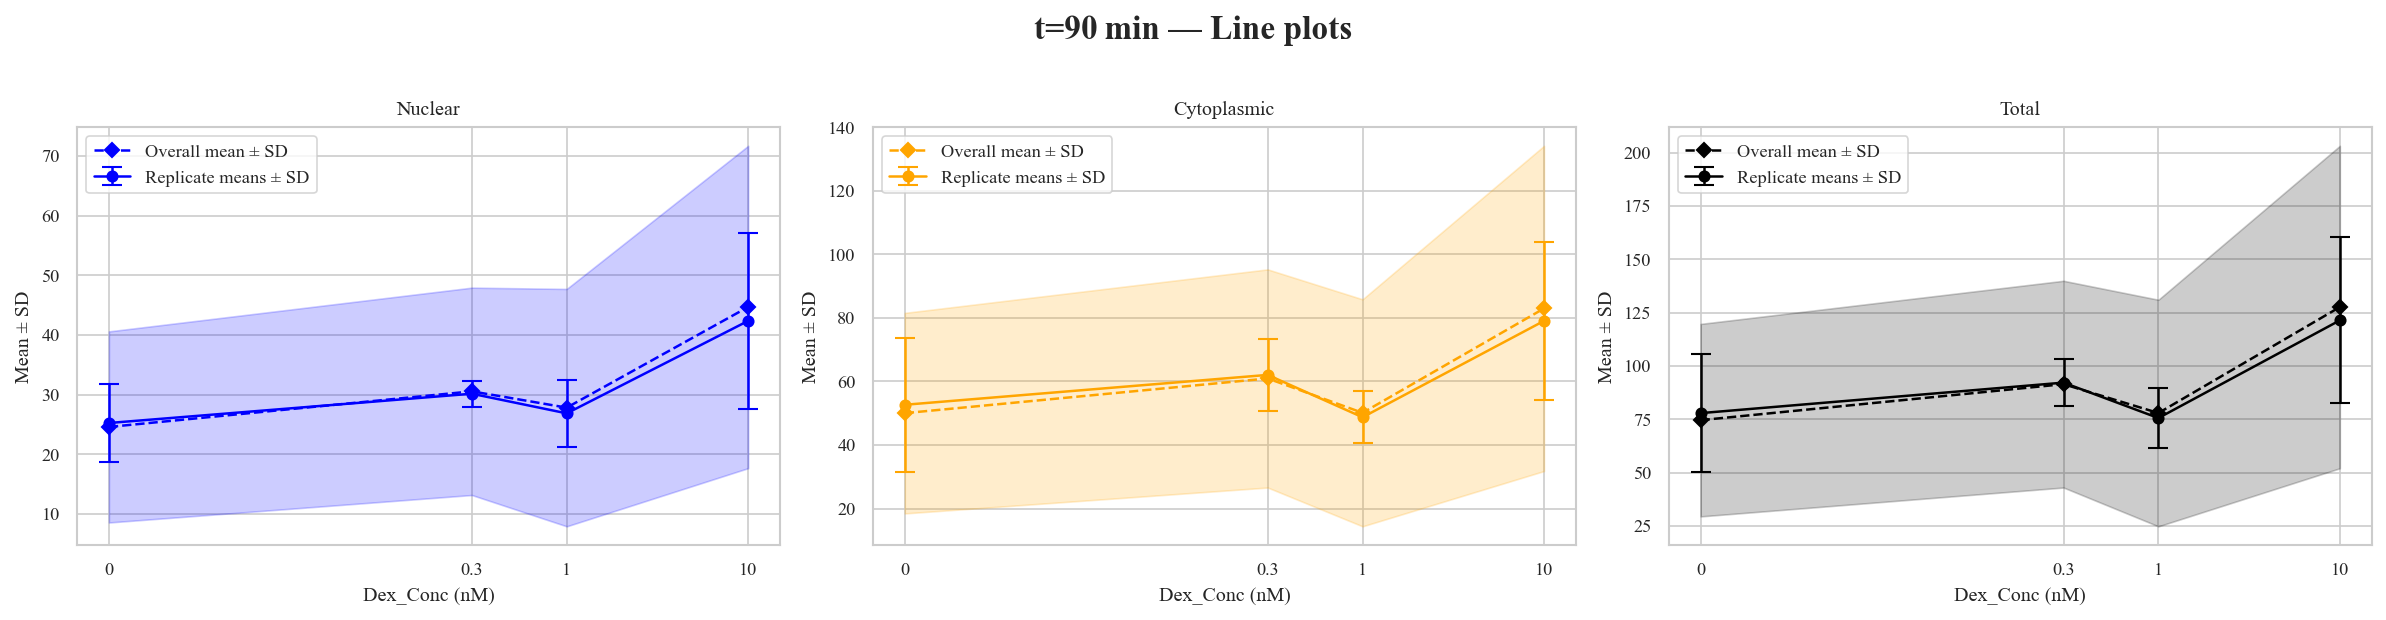

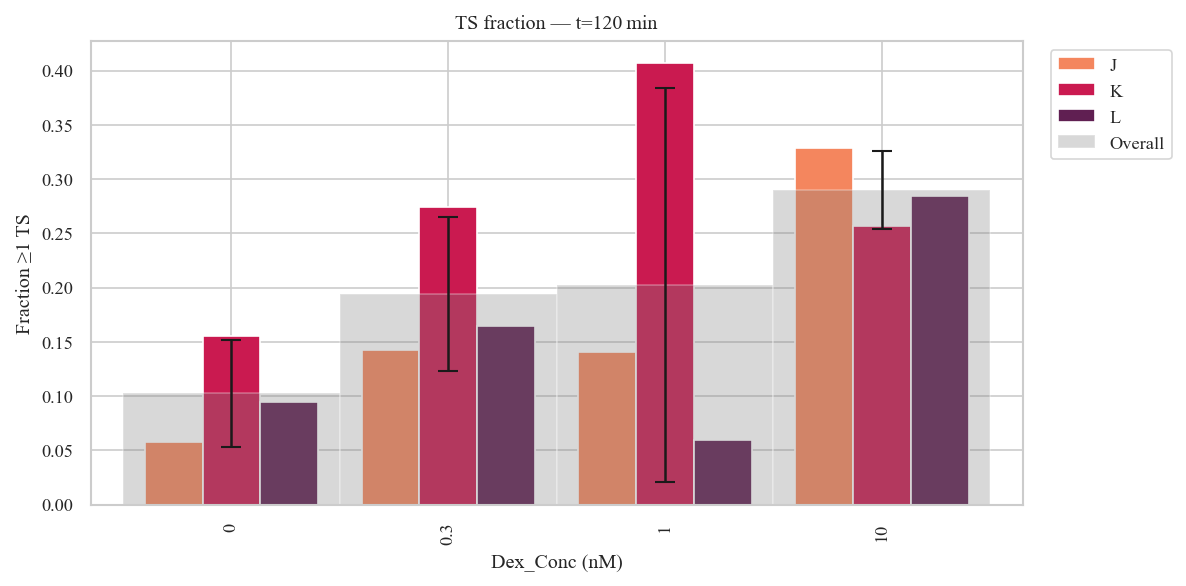

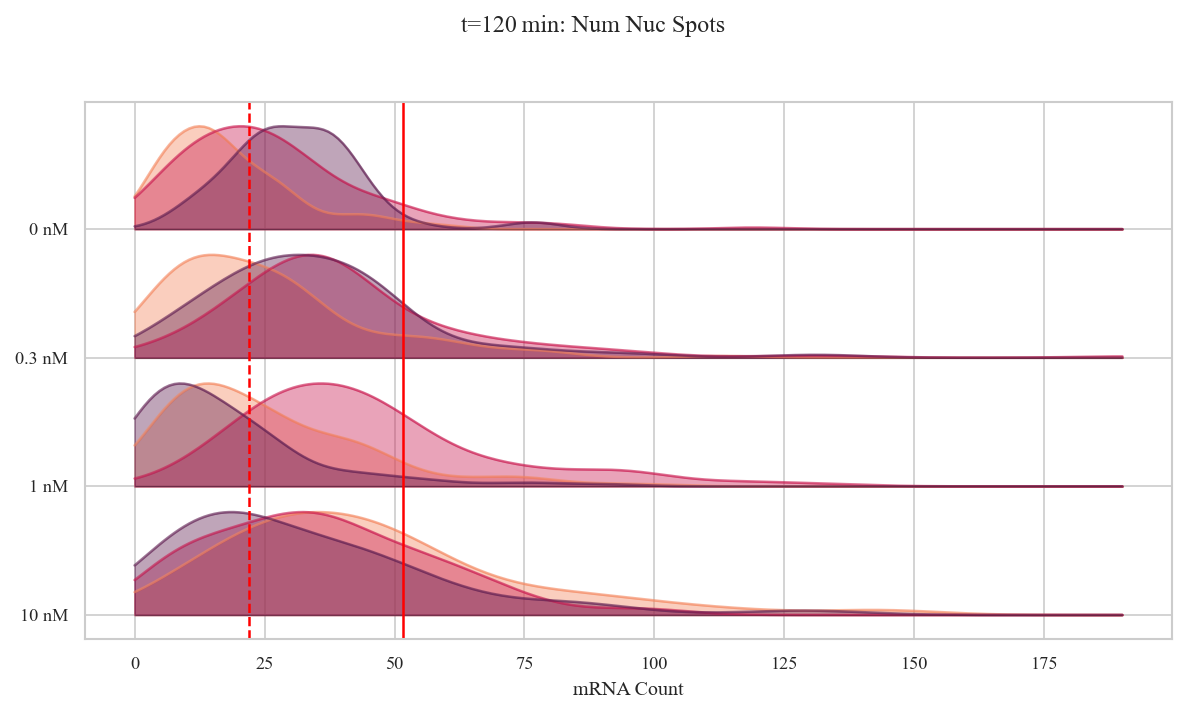

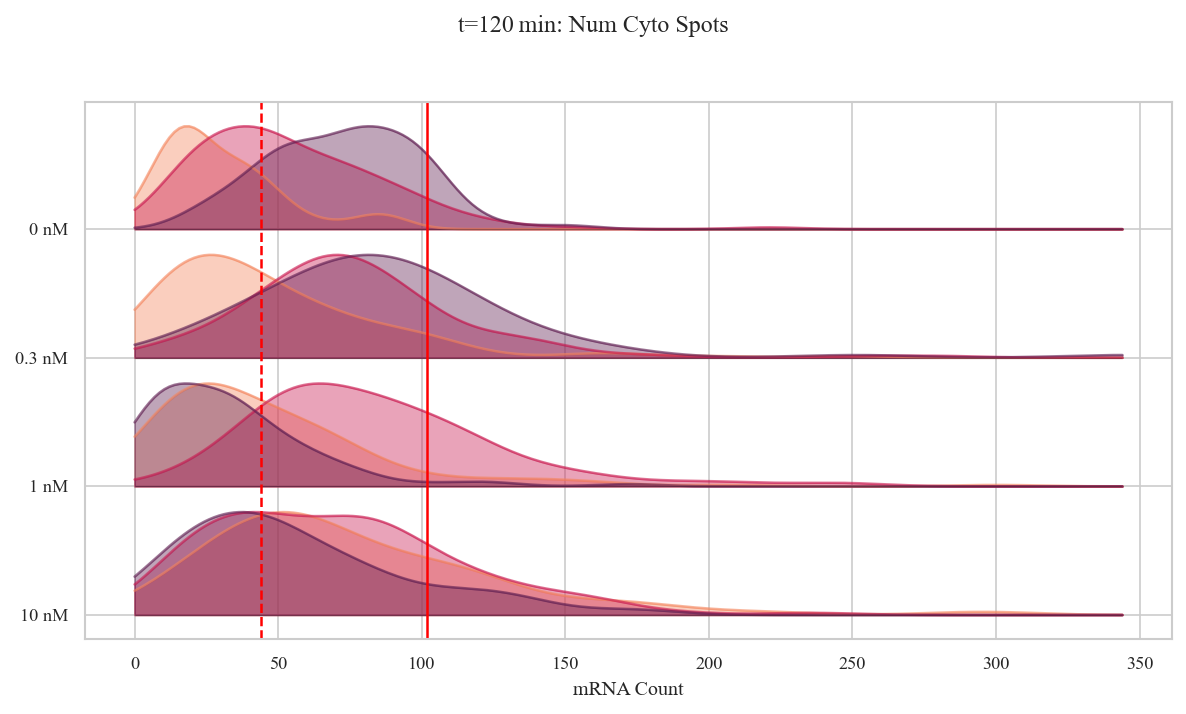

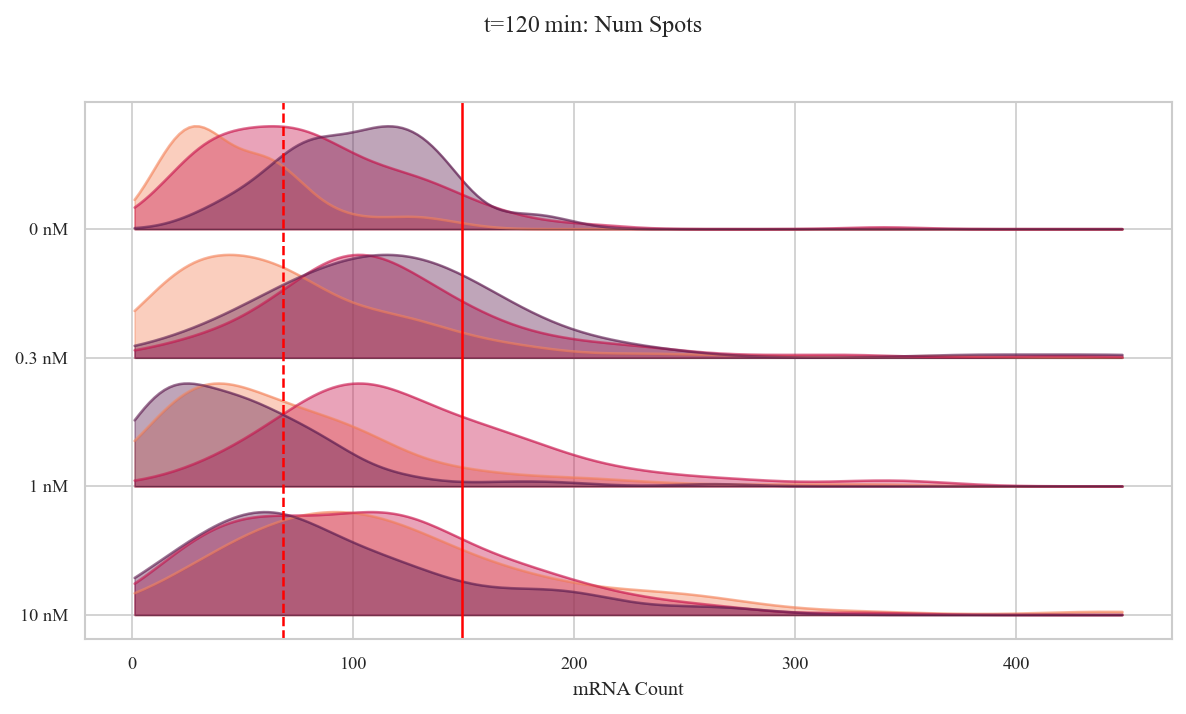

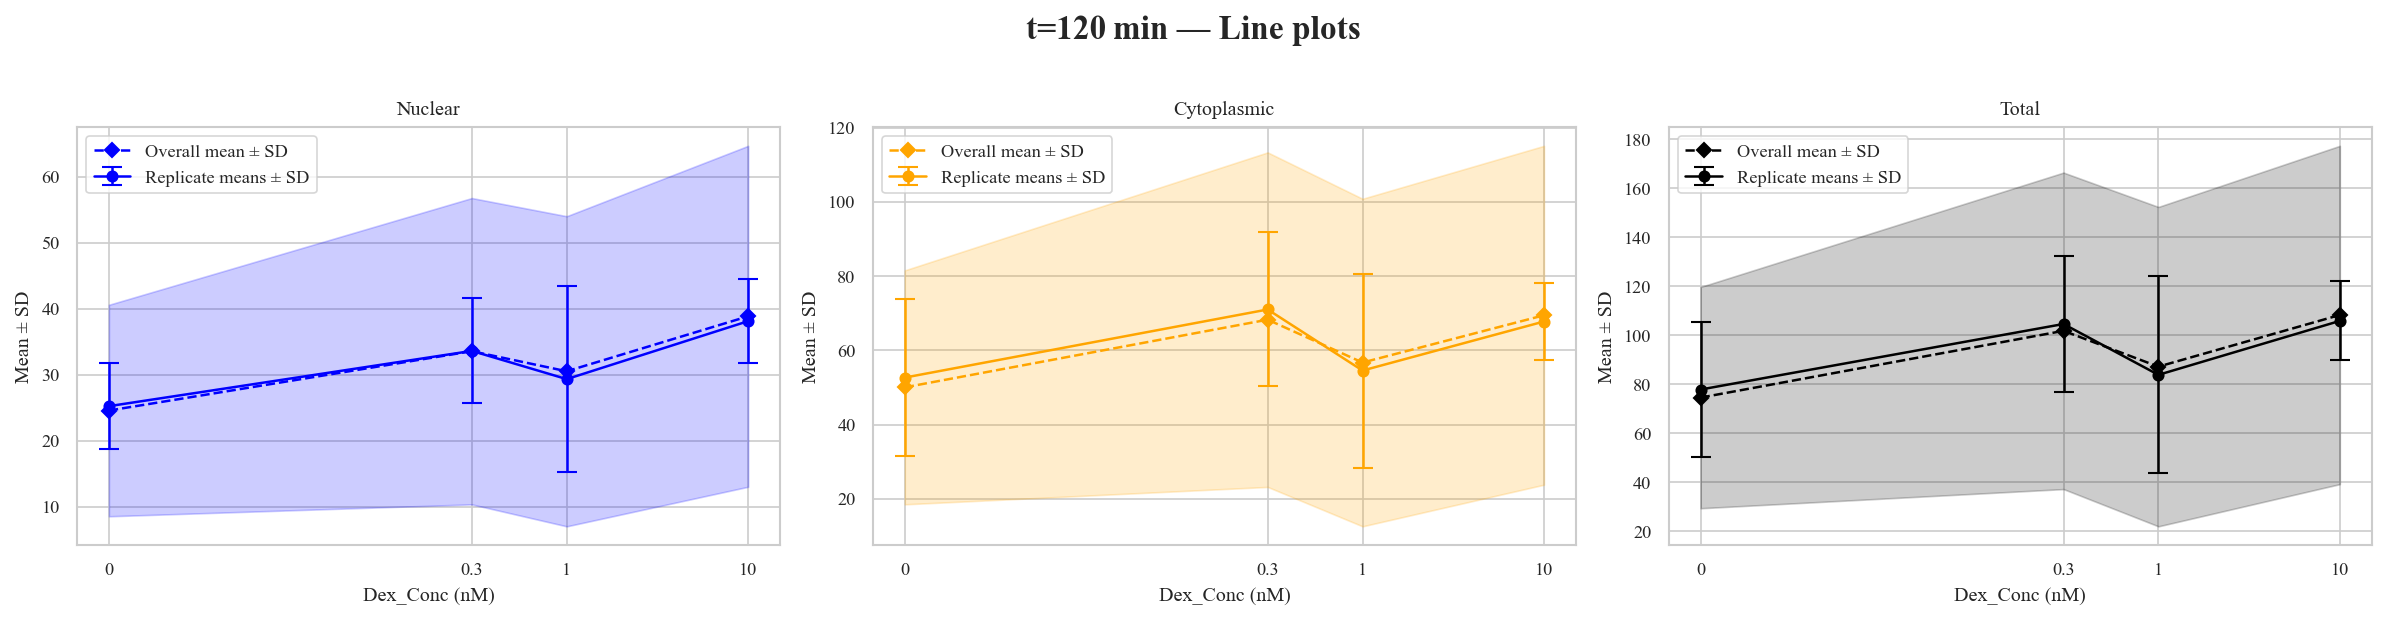

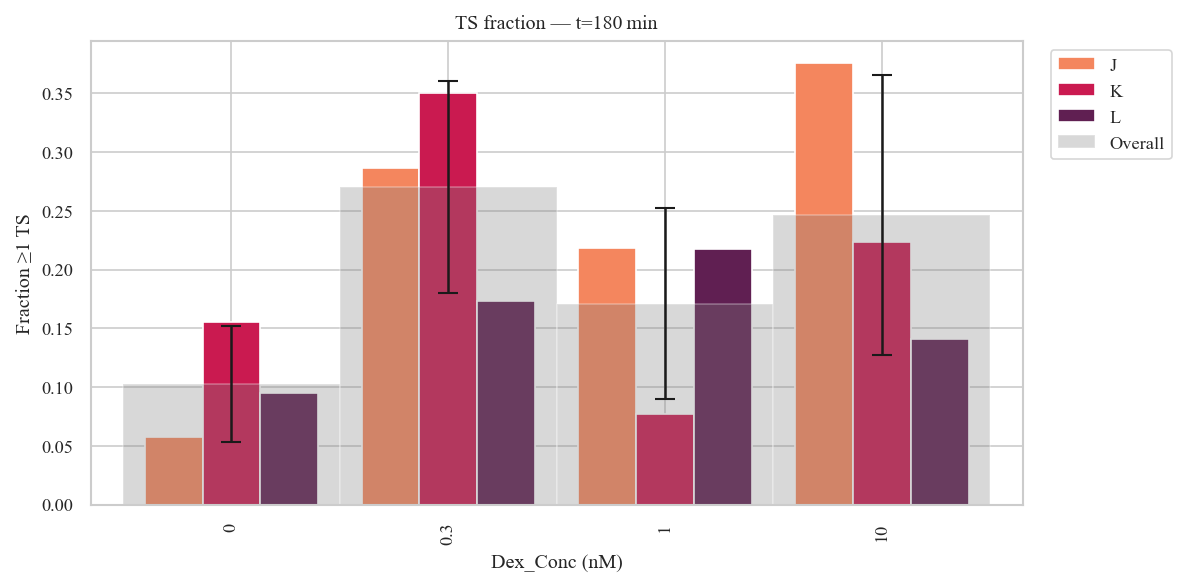

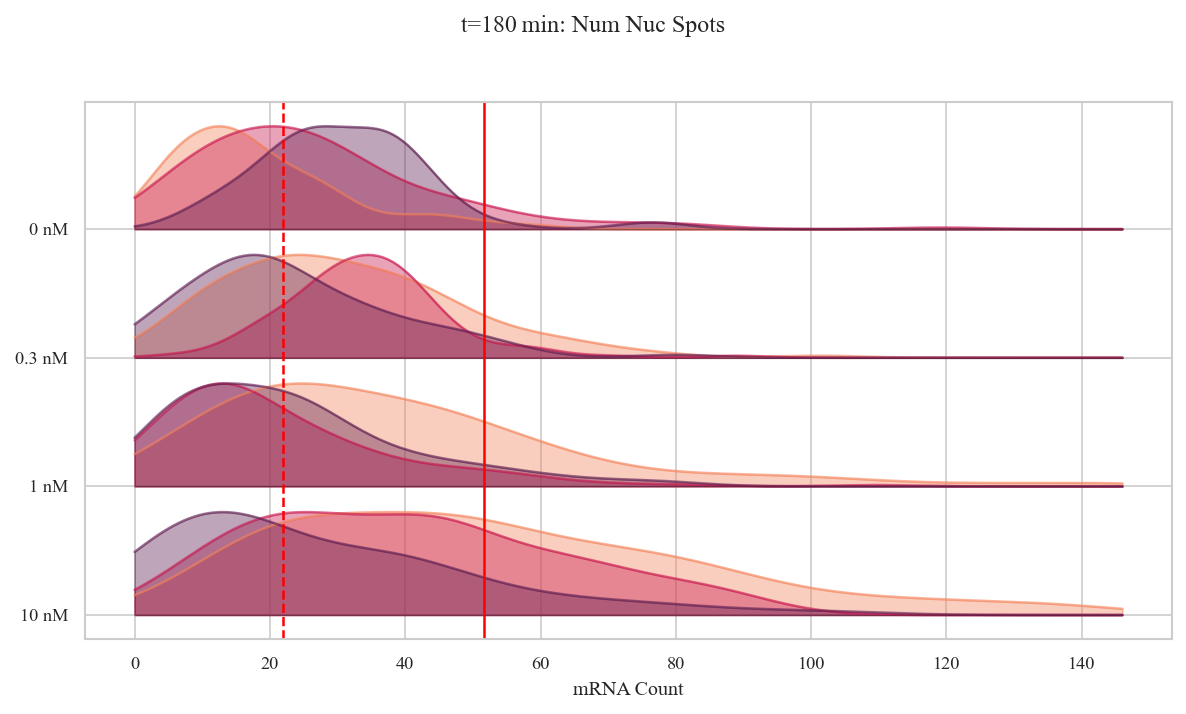

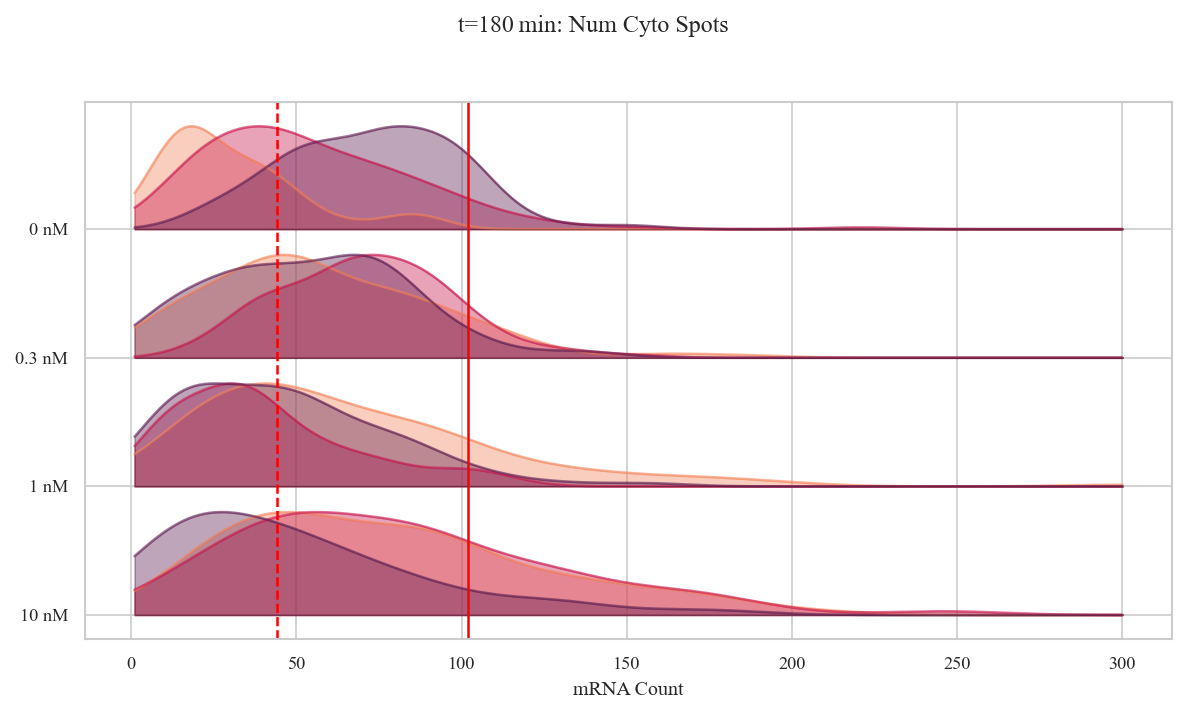

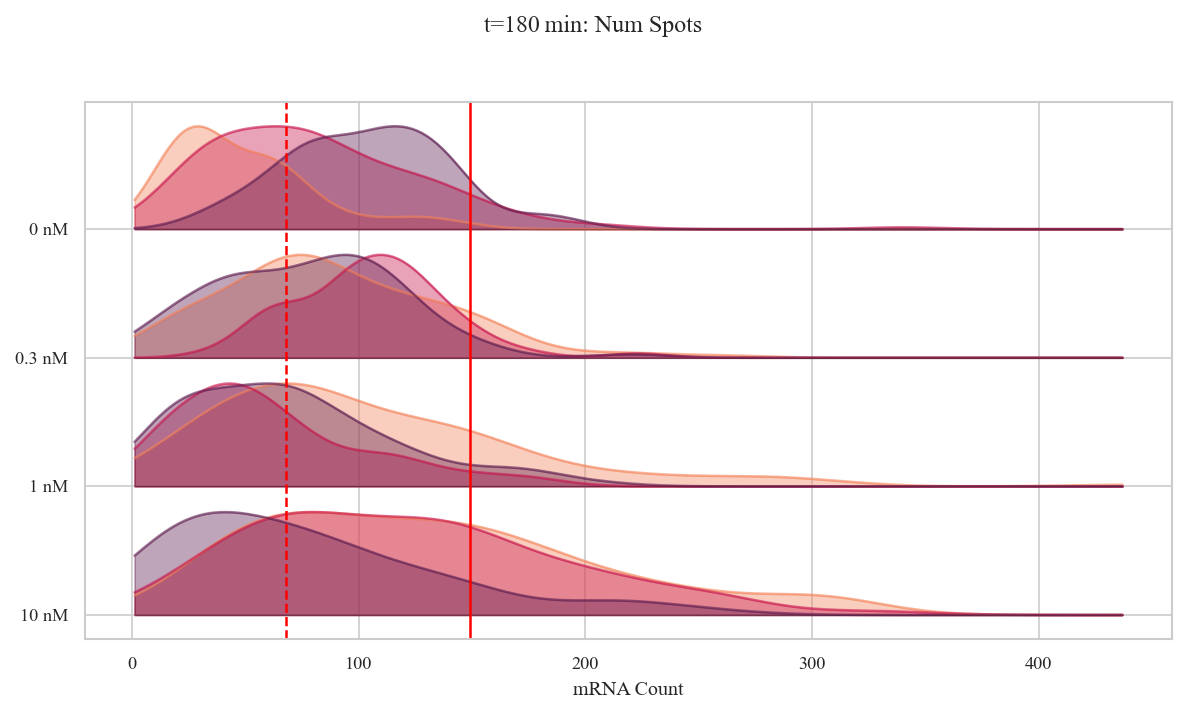

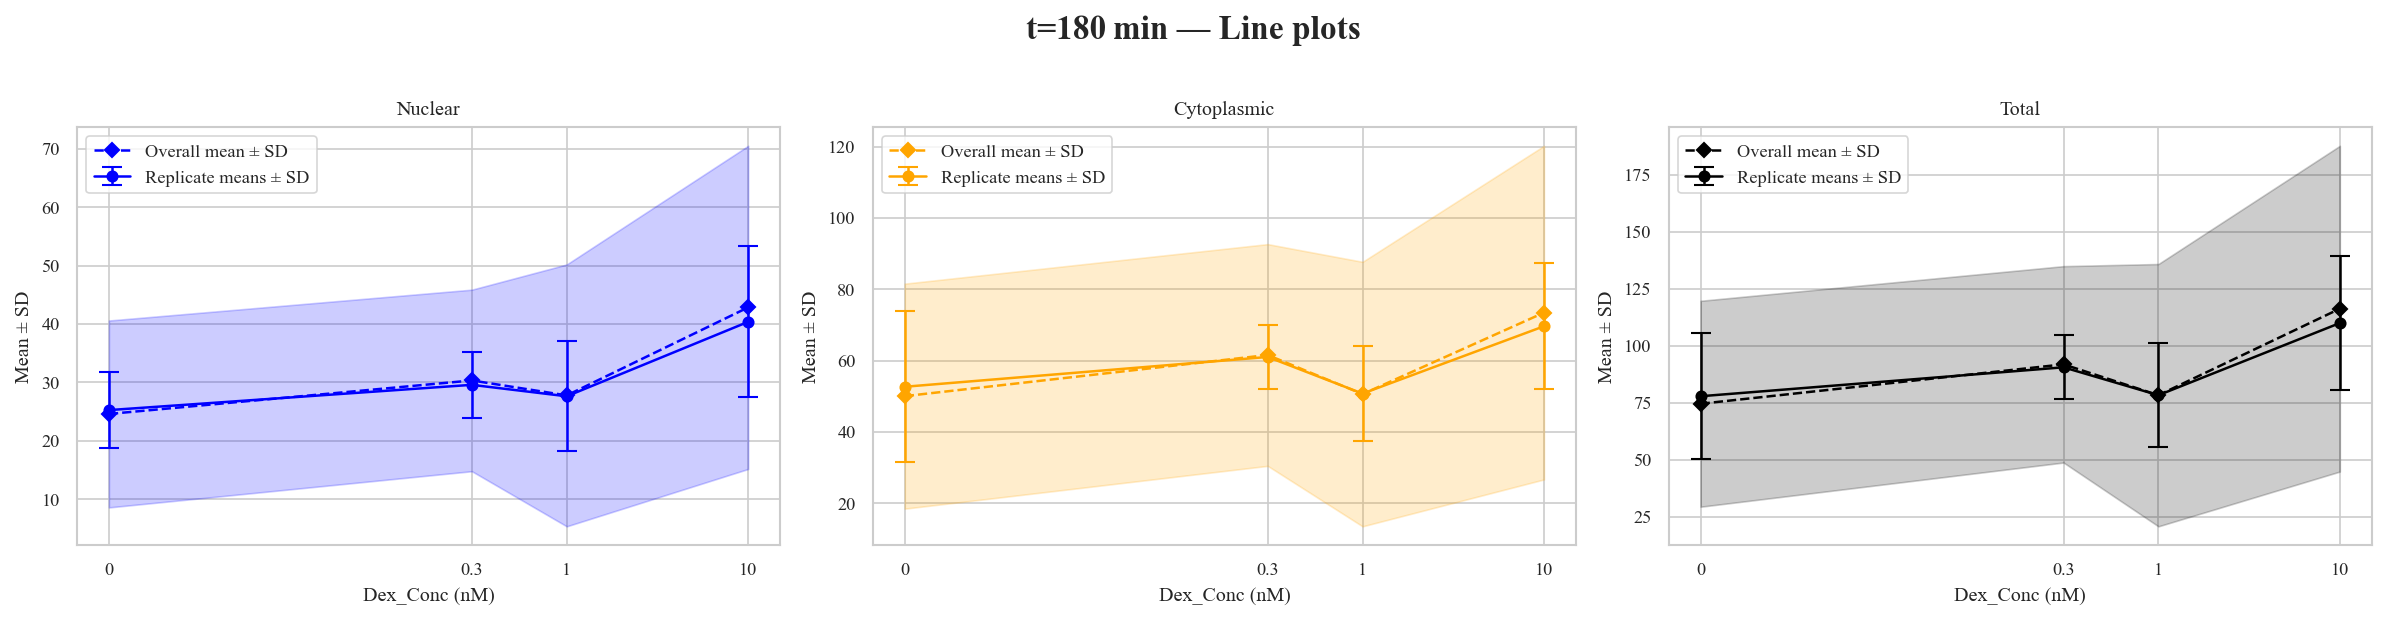

In [6]:
plotter = ExperimentPlotter(ssit_gated)

# 1) 100 nM Time Sweep:
plotter.plot_experiment(
    replicas=['D','E','F','M','N'],
    times=[10,20,30,40,50,60,75,90,120,150,180],
    concs=[100],
    save_dir=save_dir
)

# 2) 75 min Conc Sweep:
plotter.plot_experiment(
    replicas=['G','H','I'],
    times=[75],
    concs=[0.001,0.01,0.1,1,10,100,1000,10000],
    save_dir=save_dir
)

# 3) Both‐varying: 0.3,1,10 nM across multiple times:
plotter.plot_experiment(
    replicas=['J','K','L'],
    times=[30,50,75,90,120,180],
    concs=[0.3,1,10],
    save_dir=save_dir
)

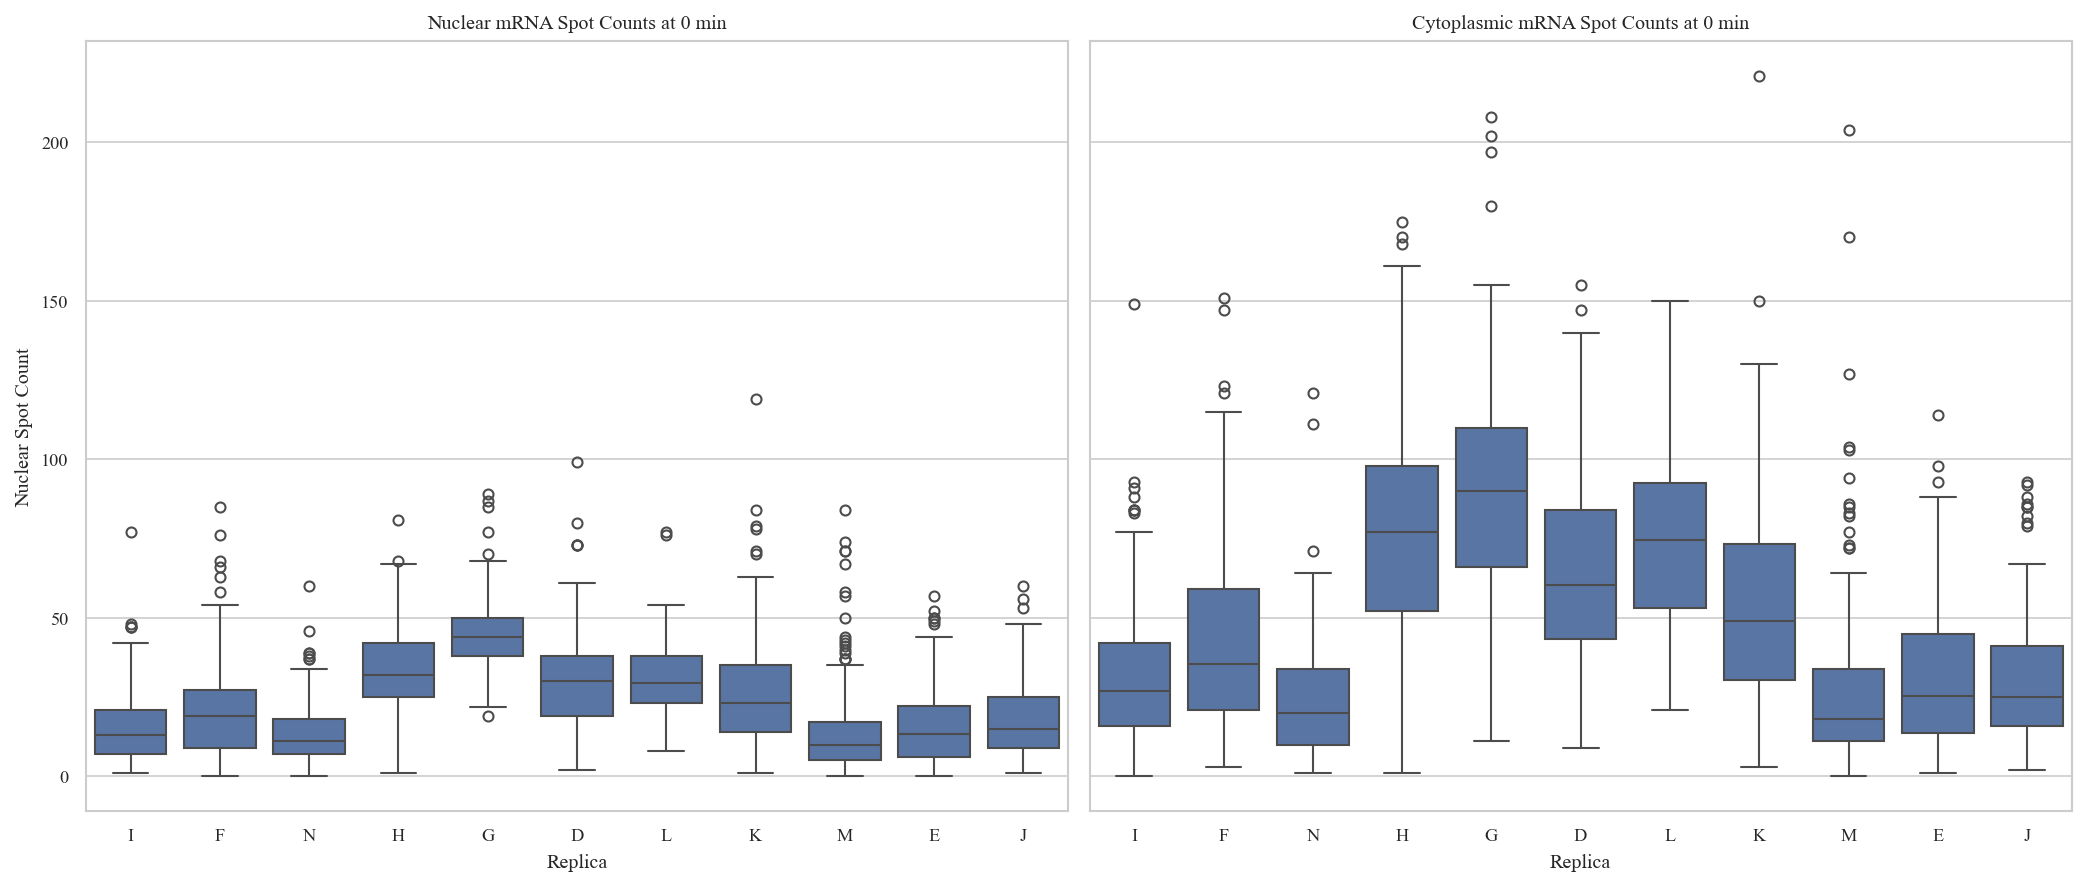

In [7]:
## Cytoplasmic and Nuclear mRNA Spot Counts at 0 min

# Make a copy of the DUSP1 data
DUSP1_data = ssit_gated.copy()

# Subset data for 0 min time points
df_0min = DUSP1_data[DUSP1_data['time'] == 0]

# Plot distribution of nuclear and cytoplasmic mRNA spots across replicas for 0 min time point
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(data=df_0min, x='replica', y='num_nuc_spots', ax=axes[0])
axes[0].set_title('Nuclear mRNA Spot Counts at 0 min')
axes[0].set_ylabel('Nuclear Spot Count')
axes[0].set_xlabel('Replica')

sns.boxplot(data=df_0min, x='replica', y='num_cyto_spots', ax=axes[1])
axes[1].set_title('Cytoplasmic mRNA Spot Counts at 0 min')
axes[1].set_ylabel('Cytoplasmic Spot Count')
axes[1].set_xlabel('Replica')

plt.tight_layout()
plt.show()